In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import ccf, grangercausalitytests
from statsmodels.stats.diagnostic import het_white
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv(r"C:\Users\hp\Documents\GitHub\Forecast_Treasury_Curve\Dataset\final_feature_library_all_features.csv")

In [5]:
data['Spread'] = data['USGG10YR_mean'] - data['USGG2YR_mean']

In [17]:
data['Spread'] = data['Spread'].shift(-1)

In [18]:
data = data[:-1]

In [19]:
cols = data.isna().sum()[data.isna().sum()==0].index.tolist()
data = data[cols]

In [28]:
data.drop(columns=['USYC2Y10_Index_median'],inplace=True)

In [30]:
# Drop all columns ending with 'median' from the data DataFrame
data = data.loc[:, ~data.columns.str.endswith('median')]

# LightGBM Model

In [31]:
# Assuming 'data' is your DataFrame with 'Spread' column and other potential features
test_size = 36

def create_lead_lag_features(df, target_col='Spread', other_cols=None, max_lags=5, max_leads=3):
    """
    Create lead and lag features for time series analysis
    """
    feature_df = df.copy()
    
    # If no other columns specified, use all numeric columns except target
    if other_cols is None:
        other_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                     if col != target_col]
    
    # Create lag features for target variable
    print(f"Creating lag features for {target_col}...")
    for lag in range(1, max_lags + 1):
        feature_df[f'{target_col}_lag_{lag}'] = feature_df[target_col].shift(lag)
    
    # # Create lead features for target variable (if available)
    # print(f"Creating lead features for {target_col}...")
    # for lead in range(1, max_leads + 1):
    #     feature_df[f'{target_col}_lead_{lead}'] = feature_df[target_col].shift(-lead)
    
    # Create lag and lead features for other variables
    for col in other_cols:
        print(f"Creating features for {col}...")
        
        # Lag features
        for lag in range(1, max_lags + 1):
            feature_df[f'{col}_lag_{lag}'] = feature_df[col].shift(lag)
        
        # # Lead features
        # for lead in range(1, max_leads + 1):
        #     feature_df[f'{col}_lead_{lead}'] = feature_df[col].shift(-lead)
        
        # Additional statistical features
        # Rolling statistics
        for window in [3, 5, 10]:
            feature_df[f'{col}_rolling_mean_{window}'] = feature_df[col].rolling(window).mean()
            feature_df[f'{col}_rolling_std_{window}'] = feature_df[col].rolling(window).std()
            feature_df[f'{col}_rolling_min_{window}'] = feature_df[col].rolling(window).min()
            feature_df[f'{col}_rolling_max_{window}'] = feature_df[col].rolling(window).max()
        
        # Differencing features
        feature_df[f'{col}_diff_1'] = feature_df[col].diff(1)
        feature_df[f'{col}_diff_2'] = feature_df[col].diff(2)
        
        # Percentage change
        feature_df[f'{col}_pct_change'] = feature_df[col].pct_change()
        
        # Momentum features
        feature_df[f'{col}_momentum_3'] = feature_df[col] - feature_df[col].shift(3)
        feature_df[f'{col}_momentum_5'] = feature_df[col] - feature_df[col].shift(5)
    
    return feature_df

def correlation_analysis(df, target_col='Spread', threshold=0.1):
    """
    Perform correlation analysis between features and target
    """
    print(f"\n{'='*80}")
    print("CORRELATION ANALYSIS")
    print(f"{'='*80}")
    
    # Calculate correlations with target
    feature_cols = [col for col in df.columns if col != target_col and df[col].dtype in ['float64', 'int64']]
    correlations = []
    
    for col in feature_cols:
        # Remove rows where either target or feature is NaN
        clean_data = df[[target_col, col]].dropna()
        
        if len(clean_data) > 10:  # Need minimum data points
            # Pearson correlation
            pearson_corr, pearson_p = pearsonr(clean_data[target_col], clean_data[col])
            
            # Spearman correlation
            spearman_corr, spearman_p = spearmanr(clean_data[target_col], clean_data[col])
            
            correlations.append({
                'Feature': col,
                'Pearson_Corr': pearson_corr,
                'Pearson_P_Value': pearson_p,
                'Spearman_Corr': spearman_corr,
                'Spearman_P_Value': spearman_p,
                'Abs_Pearson': abs(pearson_corr),
                'Sample_Size': len(clean_data)
            })
    
    corr_df = pd.DataFrame(correlations)
    
    # Filter significant correlations above threshold
    significant_features = corr_df[
        (corr_df['Abs_Pearson'] > threshold) & 
        (corr_df['Pearson_P_Value'] < 0.05)
    ].sort_values('Abs_Pearson', ascending=False)
    
    print(f"Features with |correlation| > {threshold} and p-value < 0.05:")
    print(f"{'Feature':<30} {'Pearson':<10} {'P-Value':<10} {'Spearman':<10} {'Sample':<8}")
    print(f"{'-'*80}")
    
    for _, row in significant_features.head(20).iterrows():
        print(f"{row['Feature']:<30} {row['Pearson_Corr']:<10.4f} {row['Pearson_P_Value']:<10.4f} "
              f"{row['Spearman_Corr']:<10.4f} {row['Sample_Size']:<8.0f}")
    
    return corr_df, significant_features

def cross_correlation_analysis(df, target_col='Spread', other_cols=None, max_lags=10):
    """
    Perform cross-correlation analysis to find optimal lead-lag relationships
    """
    print(f"\n{'='*80}")
    print("CROSS-CORRELATION ANALYSIS")
    print(f"{'='*80}")
    
    if other_cols is None:
        other_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                     if col != target_col and not col.startswith(target_col)]
    
    ccf_results = {}
    
    for col in other_cols[:5]:  # Limit to first 5 for demonstration
        try:
            # Remove NaN values
            clean_data = df[[target_col, col]].dropna()
            
            if len(clean_data) > 50:  # Need sufficient data
                # Calculate cross-correlation
                ccf_values = ccf(clean_data[col], clean_data[target_col], adjusted=False)
                
                # Find optimal lag
                optimal_lag = np.argmax(np.abs(ccf_values[:max_lags+1]))
                optimal_ccf = ccf_values[optimal_lag]
                
                ccf_results[col] = {
                    'optimal_lag': optimal_lag,
                    'optimal_ccf': optimal_ccf,
                    'ccf_values': ccf_values[:max_lags+1]
                }
                
                print(f"{col:<20}: Optimal lag = {optimal_lag}, CCF = {optimal_ccf:.4f}")
        
        except Exception as e:
            print(f"Error calculating CCF for {col}: {str(e)}")
    
    return ccf_results

def granger_causality_test(df, target_col='Spread', other_cols=None, max_lags=5):
    """
    Perform Granger causality test
    """
    print(f"\n{'='*80}")
    print("GRANGER CAUSALITY ANALYSIS")
    print(f"{'='*80}")
    
    if other_cols is None:
        other_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                     if col != target_col and not col.startswith(target_col)]
    
    granger_results = {}
    
    for col in other_cols[:5]:  # Limit for demonstration
        try:
            # Prepare data
            test_data = df[[target_col, col]].dropna()
            
            if len(test_data) > 50:
                # Perform Granger causality test
                gc_result = grangercausalitytests(test_data, maxlag=max_lags, verbose=False)
                
                # Extract p-values for each lag
                p_values = []
                for lag in range(1, max_lags + 1):
                    p_value = gc_result[lag][0]['ssr_ftest'][1]  # F-test p-value
                    p_values.append(p_value)
                
                # Find best lag (minimum p-value)
                best_lag = np.argmin(p_values) + 1
                best_p_value = min(p_values)
                
                granger_results[col] = {
                    'best_lag': best_lag,
                    'best_p_value': best_p_value,
                    'all_p_values': p_values,
                    'is_significant': best_p_value < 0.05
                }
                
                significance = "Significant" if best_p_value < 0.05 else "Not Significant"
                print(f"{col:<20}: Best lag = {best_lag}, P-value = {best_p_value:.4f} ({significance})")
        
        except Exception as e:
            print(f"Error in Granger test for {col}: {str(e)}")
    
    return granger_results

def mutual_information_analysis(df, target_col='Spread', top_n=20):
    """
    Calculate mutual information between features and target
    """
    print(f"\n{'='*80}")
    print("MUTUAL INFORMATION ANALYSIS")
    print(f"{'='*80}")
    
    # Prepare features
    feature_cols = [col for col in df.columns if col != target_col and df[col].dtype in ['float64', 'int64']]
    
    # Remove rows with NaN in target
    clean_df = df.dropna(subset=[target_col])
    
    # Prepare feature matrix
    X = clean_df[feature_cols].fillna(clean_df[feature_cols].mean())  # Simple imputation
    y = clean_df[target_col]
    
    # Calculate mutual information
    mi_scores = mutual_info_regression(X, y, random_state=42)
    
    # Create results DataFrame
    mi_results = pd.DataFrame({
        'Feature': feature_cols,
        'MI_Score': mi_scores
    }).sort_values('MI_Score', ascending=False)
    
    print(f"Top {top_n} features by Mutual Information:")
    print(f"{'Feature':<40} {'MI Score':<10}")
    print(f"{'-'*60}")
    
    for _, row in mi_results.head(top_n).iterrows():
        print(f"{row['Feature']:<40} {row['MI_Score']:<10.6f}")
    
    return mi_results

def feature_importance_regression(df, target_col='Spread', test_size=36):
    """
    Use linear regression to assess feature importance
    """
    print(f"\n{'='*80}")
    print("LINEAR REGRESSION FEATURE IMPORTANCE")
    print(f"{'='*80}")
    
    # Prepare data
    feature_cols = [col for col in df.columns if col != target_col and df[col].dtype in ['float64', 'int64']]
    
    # Remove rows with NaN in target and split train/test
    clean_df = df.dropna(subset=[target_col])
    train_df = clean_df[:-test_size]
    test_df = clean_df[-test_size:]
    
    # Prepare features and target
    X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_train = train_df[target_col]
    X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())  # Use train means for test
    y_test = test_df[target_col]
    
    # Remove features with all NaN or constant values
    valid_features = []
    for col in feature_cols:
        if not X_train[col].isna().all() and X_train[col].std() > 1e-8:
            valid_features.append(col)
    
    X_train = X_train[valid_features]
    X_test = X_test[valid_features]
    
    if len(valid_features) == 0:
        print("No valid features found for regression analysis")
        return None
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit regression model
    reg = LinearRegression()
    reg.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred_train = reg.predict(X_train_scaled)
    y_pred_test = reg.predict(X_test_scaled)
    
    # Calculate performance metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(f"Model Performance:")
    print(f"Train MAE: {train_mae:.4f}, Train R²: {train_r2:.4f}")
    print(f"Test MAE:  {test_mae:.4f}, Test R²:  {test_r2:.4f}")
    
    # Feature importance (absolute coefficients)
    feature_importance = pd.DataFrame({
        'Feature': valid_features,
        'Coefficient': reg.coef_,
        'Abs_Coefficient': np.abs(reg.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print(f"\nTop 15 Most Important Features:")
    print(f"{'Feature':<40} {'Coefficient':<12} {'Abs_Coef':<10}")
    print(f"{'-'*70}")
    
    for _, row in feature_importance.head(15).iterrows():
        print(f"{row['Feature']:<40} {row['Coefficient']:<12.6f} {row['Abs_Coefficient']:<10.6f}")
    
    return {
        'model': reg,
        'scaler': scaler,
        'feature_importance': feature_importance,
        'valid_features': valid_features,
        'performance': {
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_r2': train_r2,
            'test_r2': test_r2
        }
    }

def comprehensive_feature_analysis(data, target_col='Spread', other_features=None):
    """
    Run comprehensive feature engineering and analysis
    """
    print("Starting Comprehensive Feature Engineering and Analysis...")
    print(f"Original data shape: {data.shape}")
    
    # Step 1: Create lead-lag features
    print("\n1. Creating Lead-Lag Features...")
    feature_data = create_lead_lag_features(
        data, 
        target_col=target_col, 
        other_cols=other_features,
        max_lags=5, 
        max_leads=2
    )
    
    print(f"After feature engineering: {feature_data.shape}")
    
    # Step 2: Correlation Analysis
    corr_results, significant_features = correlation_analysis(feature_data, target_col)
    
    # Step 3: Cross-correlation Analysis
    ccf_results = cross_correlation_analysis(feature_data, target_col, other_features)
    
    # Step 4: Granger Causality Test
    granger_results = granger_causality_test(feature_data, target_col, other_features)
    
    # Step 5: Mutual Information Analysis
    mi_results = mutual_information_analysis(feature_data, target_col)
    
    # Step 6: Linear Regression Feature Importance
    regression_results = feature_importance_regression(feature_data, target_col)
    
    # Summary of recommendations
    print(f"\n{'='*80}")
    print("FEATURE SELECTION RECOMMENDATIONS")
    print(f"{'='*80}")
    
    # Combine insights from different analyses
    recommended_features = set()
    
    # From correlation analysis
    if len(significant_features) > 0:
        top_corr_features = significant_features.head(10)['Feature'].tolist()
        recommended_features.update(top_corr_features)
        print(f"Top correlation features: {top_corr_features[:5]}")
    
    # From mutual information
    top_mi_features = mi_results.head(10)['Feature'].tolist()
    recommended_features.update(top_mi_features)
    print(f"Top MI features: {top_mi_features[:5]}")
    
    # From regression importance
    if regression_results and len(regression_results['feature_importance']) > 0:
        top_reg_features = regression_results['feature_importance'].head(10)['Feature'].tolist()
        recommended_features.update(top_reg_features)
        print(f"Top regression features: {top_reg_features[:5]}")
    
    print(f"\nTotal recommended features: {len(recommended_features)}")
    print(f"Recommended features: {list(recommended_features)[:10]}")
    
    return {
        'feature_data': feature_data,
        'correlation_results': corr_results,
        'significant_features': significant_features,
        'ccf_results': ccf_results,
        'granger_results': granger_results,
        'mi_results': mi_results,
        'regression_results': regression_results,
        'recommended_features': list(recommended_features)
    }

# Example usage - you'll need to specify your other feature columns
# If you only have 'Spread', we'll create synthetic features for demonstration
if 'data' in locals():
    # Replace this with your actual feature columns
    # For example: other_features = ['Price', 'Volume', 'Interest_Rate', 'Volatility']
    other_features = None  # Will use all numeric columns except target
    
    # Run comprehensive analysis
    analysis_results = comprehensive_feature_analysis(
        data=data,
        target_col='Spread',
        other_features=other_features
    )
    
    print("\nFeature engineering and analysis completed!")
    print("Use 'analysis_results' to access all results and recommendations.")
else:
    print("Please ensure 'data' DataFrame is available with your time series data.")

Starting Comprehensive Feature Engineering and Analysis...
Original data shape: (302, 20)

1. Creating Lead-Lag Features...
Creating lag features for Spread...
Creating features for USGG2YR_mean...
Creating features for USGG5YR_mean...
Creating features for USGG10YR_mean...
Creating features for USGG30YR_mean...
Creating features for FEDL01_Index_mean...
Creating features for VIX_Index_mean...
Creating features for MOVE_Index_mean...
Creating features for USGG5Y5Y_Index_mean...
Creating features for USYC5Y30_Index_mean...
Creating features for USYC1030_Index_mean...
Creating features for USYC2Y10_Index_mean...
Creating features for USDCNY_Curncy_mean...
Creating features for EUR_Curncy_mean...
Creating features for EUR003M_Index_mean...
Creating features for GDBR10_Index_mean...
Creating features for CO1_Comdty_mean...
Creating features for USDCHF_BGN_Curncy_mean...
Creating features for TBSM6M_Index_mean...
After feature engineering: (302, 421)

CORRELATION ANALYSIS
Features with |cor

LIGHTGBM FORECASTING ANALYSIS PIPELINE
Preparing data for forecasting...
Original feature data shape: (302, 421)
After removing NaN targets: (302, 421)
Initial feature columns: 20
Valid features after filtering: 20
Train set shape: (266, 421)
Test set shape: (36, 421)

LIGHTGBM CROSS-VALIDATION
Performing 5-fold time series cross-validation...

Fold 1/5
  Train size: 46
  Validation size: 44
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[319]	valid_0's l1: 0.228826
  Validation MAE: 0.241551
  Validation RMSE: 0.320823
  Validation R²: 0.865274
  Best iteration: 319

Fold 2/5
  Train size: 90
  Validation size: 44
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[251]	valid_0's l1: 0.39566
  Validation MAE: 0.395660
  Validation RMSE: 0.476328
  Validation R²: 0.501611
  Best iteration: 251

Fold 3/5
  Train size: 134
  Validation size: 44
Training until validation scores don't improve for 

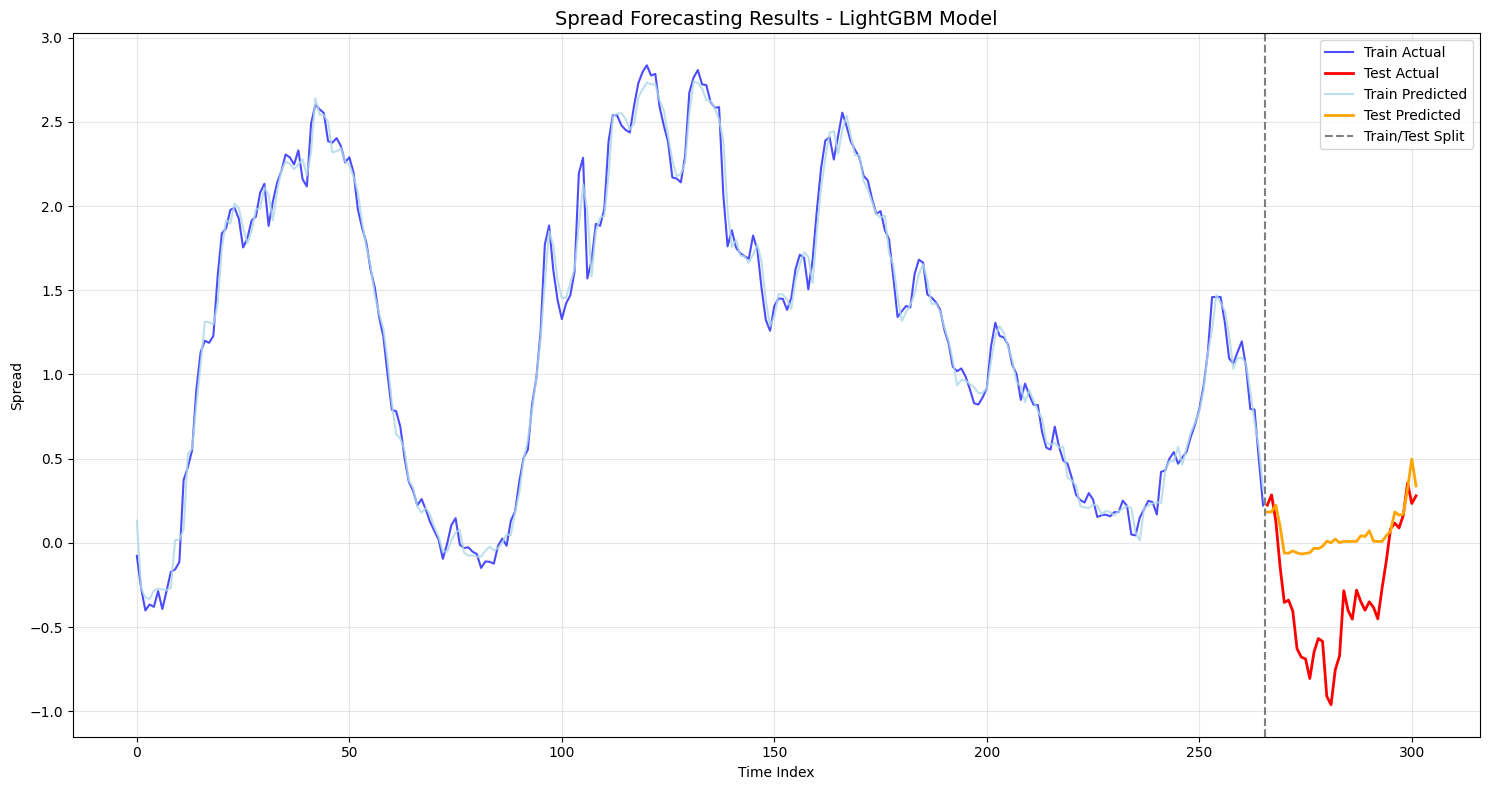


ANALYSIS COMPLETED!
Results stored in 'lightgbm_results' dictionary
Key metrics:
Cross-validation MAE: 0.207559 ± 0.119731
Final test MAE: 0.375266


In [34]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def prepare_forecasting_data(feature_data, target_col='Spread', test_size=36, 
                           recommended_features=None, feature_selection_threshold=0.01):
    """
    Prepare data for LightGBM forecasting
    """
    print(f"Preparing data for forecasting...")
    print(f"Original feature data shape: {feature_data.shape}")
    
    # Remove rows where target is NaN
    clean_data = feature_data.dropna(subset=[target_col]).copy()
    print(f"After removing NaN targets: {clean_data.shape}")
    
    # Define feature columns
    if recommended_features is not None:
        # Use recommended features from analysis
        feature_cols = [col for col in recommended_features if col in clean_data.columns and col != target_col]
    else:
        # Use all numeric columns except target and lead features (for forecasting)
        feature_cols = [col for col in clean_data.columns 
                       if col != target_col 
                       and clean_data[col].dtype in ['float64', 'int64']
                       and not col.endswith('_lead_1')  # Exclude lead features for proper forecasting
                       and not col.endswith('_lead_2')
                       and not col.endswith('_lead_3')]
    
    print(f"Initial feature columns: {len(feature_cols)}")
    
    # Remove features with too many NaN values or constant values
    valid_features = []
    for col in feature_cols:
        # Check for sufficient non-NaN values
        non_nan_ratio = clean_data[col].notna().sum() / len(clean_data)
        # Check for sufficient variance
        if non_nan_ratio > 0.7 and clean_data[col].std() > feature_selection_threshold:
            valid_features.append(col)
        else:
            print(f"Removed {col}: NaN ratio = {1-non_nan_ratio:.3f}, Std = {clean_data[col].std():.6f}")
    
    print(f"Valid features after filtering: {len(valid_features)}")
    
    # Split train and test sets
    train_data = clean_data[:-test_size].copy()
    test_data = clean_data[-test_size:].copy()
    
    print(f"Train set shape: {train_data.shape}")
    print(f"Test set shape: {test_data.shape}")
    
    return train_data, test_data, valid_features

def lightgbm_cross_validation(train_data, test_data, valid_features, target_col='Spread', 
                            n_splits=5, random_state=42):
    """
    Perform time series cross-validation with LightGBM
    """
    print(f"\n{'='*80}")
    print("LIGHTGBM CROSS-VALIDATION")
    print(f"{'='*80}")
    
    # Prepare features and target for training
    X_train_full = train_data[valid_features].fillna(train_data[valid_features].mean())
    y_train_full = train_data[target_col]
    
    # Prepare test data
    X_test = test_data[valid_features].fillna(train_data[valid_features].mean())  # Use train means
    y_test = test_data[target_col]
    
    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    cv_scores = []
    cv_models = []
    
    print(f"Performing {n_splits}-fold time series cross-validation...")
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full)):
        print(f"\nFold {fold + 1}/{n_splits}")
        
        # Split data for this fold
        X_train_fold = X_train_full.iloc[train_idx]
        y_train_fold = y_train_full.iloc[train_idx]
        X_val_fold = X_train_full.iloc[val_idx]
        y_val_fold = y_train_full.iloc[val_idx]
        
        print(f"  Train size: {len(X_train_fold)}")
        print(f"  Validation size: {len(X_val_fold)}")
        
        # Create LightGBM datasets
        train_dataset = lgb.Dataset(X_train_fold, label=y_train_fold)
        val_dataset = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_dataset)
        
        # LightGBM parameters
        params = {
            'objective': 'regression',
            'metric': 'mae',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'random_state': random_state,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1
        }
        
        # Train model
        model = lgb.train(
            params,
            train_dataset,
            valid_sets=[val_dataset],
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )
        
        # Make predictions on validation set
        y_val_pred = model.predict(X_val_fold, num_iteration=model.best_iteration)
        
        # Calculate metrics
        mae = mean_absolute_error(y_val_fold, y_val_pred)
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
        r2 = r2_score(y_val_fold, y_val_pred)
        
        cv_scores.append({
            'fold': fold + 1,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'best_iteration': model.best_iteration
        })
        
        cv_models.append(model)
        
        print(f"  Validation MAE: {mae:.6f}")
        print(f"  Validation RMSE: {rmse:.6f}")
        print(f"  Validation R²: {r2:.6f}")
        print(f"  Best iteration: {model.best_iteration}")
    
    # Cross-validation summary
    cv_df = pd.DataFrame(cv_scores)
    
    print(f"\n{'='*60}")
    print("CROSS-VALIDATION SUMMARY")
    print(f"{'='*60}")
    print(f"Mean MAE: {cv_df['mae'].mean():.6f} ± {cv_df['mae'].std():.6f}")
    print(f"Mean RMSE: {cv_df['rmse'].mean():.6f} ± {cv_df['rmse'].std():.6f}")
    print(f"Mean R²: {cv_df['r2'].mean():.6f} ± {cv_df['r2'].std():.6f}")
    print(f"Mean Best Iteration: {cv_df['best_iteration'].mean():.1f}")
    
    return cv_scores, cv_models, cv_df

def train_final_model_and_forecast(train_data, test_data, valid_features, target_col='Spread',
                                 cv_models=None, random_state=42):
    """
    Train final model on full training data and make forecasts
    """
    print(f"\n{'='*80}")
    print("FINAL MODEL TRAINING AND FORECASTING")
    print(f"{'='*80}")
    
    # Prepare full training data
    X_train = train_data[valid_features].fillna(train_data[valid_features].mean())
    y_train = train_data[target_col]
    
    # Prepare test data
    X_test = test_data[valid_features].fillna(train_data[valid_features].mean())
    y_test = test_data[target_col]
    
    # Use average best iteration from CV
    if cv_models:
        avg_best_iteration = int(np.mean([model.best_iteration for model in cv_models]))
    else:
        avg_best_iteration = 500
    
    print(f"Using {avg_best_iteration} iterations based on cross-validation")
    
    # Train final model
    train_dataset = lgb.Dataset(X_train, label=y_train)
    
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': random_state,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1
    }
    
    final_model = lgb.train(
        params,
        train_dataset,
        num_boost_round=avg_best_iteration
    )
    
    # Make predictions
    y_train_pred = final_model.predict(X_train)
    y_test_pred = final_model.predict(X_test)
    
    # Calculate final performance metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"\nFINAL MODEL PERFORMANCE:")
    print(f"{'Metric':<15} {'Train':<12} {'Test':<12}")
    print(f"{'-'*40}")
    print(f"{'MAE':<15} {train_mae:<12.6f} {test_mae:<12.6f}")
    print(f"{'RMSE':<15} {train_rmse:<12.6f} {test_rmse:<12.6f}")
    print(f"{'R²':<15} {train_r2:<12.6f} {test_r2:<12.6f}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': valid_features,
        'importance': final_model.feature_importance(importance_type='gain')
    }).sort_values('importance', ascending=False)
    
    print(f"\nTOP 15 MOST IMPORTANT FEATURES:")
    print(f"{'Feature':<40} {'Importance':<12}")
    print(f"{'-'*55}")
    for _, row in feature_importance.head(15).iterrows():
        print(f"{row['feature']:<40} {row['importance']:<12.0f}")
    
    return {
        'final_model': final_model,
        'train_predictions': y_train_pred,
        'test_predictions': y_test_pred,
        'feature_importance': feature_importance,
        'performance': {
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2
        }
    }

def plot_forecast_results(train_data, test_data, train_pred, test_pred, target_col='Spread'):
    """
    Plot forecasting results
    """
    plt.figure(figsize=(15, 8))
    
    # Create time indices
    train_idx = range(len(train_data))
    test_idx = range(len(train_data), len(train_data) + len(test_data))
    
    # Plot actual values
    plt.plot(train_idx, train_data[target_col], label='Train Actual', color='blue', alpha=0.7)
    plt.plot(test_idx, test_data[target_col], label='Test Actual', color='red', linewidth=2)
    
    # Plot predictions
    plt.plot(train_idx, train_pred, label='Train Predicted', color='lightblue', alpha=0.8)
    plt.plot(test_idx, test_pred, label='Test Predicted', color='orange', linewidth=2)
    
    # Add vertical line to separate train/test
    plt.axvline(x=len(train_data)-0.5, color='black', linestyle='--', alpha=0.5, label='Train/Test Split')
    
    plt.title(f'{target_col} Forecasting Results - LightGBM Model', fontsize=14)
    plt.xlabel('Time Index')
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def run_complete_lightgbm_analysis(feature_data, target_col='Spread', test_size=36, 
                                 recommended_features=None, n_cv_folds=5):
    """
    Run complete LightGBM analysis pipeline
    """
    print("="*100)
    print("LIGHTGBM FORECASTING ANALYSIS PIPELINE")
    print("="*100)
    
    # Step 1: Prepare data
    train_data, test_data, valid_features = prepare_forecasting_data(
        feature_data, target_col, test_size, recommended_features
    )
    
    if len(valid_features) == 0:
        print("ERROR: No valid features found for modeling!")
        return None
    
    # Step 2: Cross-validation
    cv_scores, cv_models, cv_df = lightgbm_cross_validation(
        train_data, test_data, valid_features, target_col, n_cv_folds
    )
    
    # Step 3: Train final model and forecast
    final_results = train_final_model_and_forecast(
        train_data, test_data, valid_features, target_col, cv_models
    )
    
    # Step 4: Plot results
    plot_forecast_results(
        train_data, test_data, 
        final_results['train_predictions'], 
        final_results['test_predictions'], 
        target_col
    )
    
    # Return comprehensive results
    return {
        'train_data': train_data,
        'test_data': test_data,
        'valid_features': valid_features,
        'cv_results': {
            'scores': cv_scores,
            'models': cv_models,
            'summary': cv_df
        },
        'final_results': final_results
    }

# Example usage:
# Assuming you have your feature_data from the previous analysis
if 'analysis_results' in locals():
    # Use the feature data and recommendations from your analysis
    lightgbm_results = run_complete_lightgbm_analysis(
        feature_data=analysis_results['feature_data'],
        target_col='Spread',
        test_size=36,
        recommended_features=analysis_results['recommended_features'][:50],  # Use top 50 features
        n_cv_folds=5
    )
    
    print("\n" + "="*80)
    print("ANALYSIS COMPLETED!")
    print("="*80)
    print("Results stored in 'lightgbm_results' dictionary")
    print("Key metrics:")
    if lightgbm_results:
        test_mae = lightgbm_results['final_results']['performance']['test_mae']
        cv_mae_mean = lightgbm_results['cv_results']['summary']['mae'].mean()
        cv_mae_std = lightgbm_results['cv_results']['summary']['mae'].std()
        print(f"Cross-validation MAE: {cv_mae_mean:.6f} ± {cv_mae_std:.6f}")
        print(f"Final test MAE: {test_mae:.6f}")

elif 'feature_data' in locals():
    # If you have feature_data directly
    lightgbm_results = run_complete_lightgbm_analysis(
        feature_data=feature_data,
        target_col='Spread',
        test_size=36,
        n_cv_folds=5
    )

else:
    print("Please ensure you have either 'analysis_results' or 'feature_data' available.")
    print("Run the feature engineering code first, then execute this LightGBM analysis.")

COMPLETE ROLLING WINDOW FORECASTING ANALYSIS
Preparing data for forecasting...
Original feature data shape: (302, 421)
After removing NaN targets: (302, 421)
Initial feature columns: 20
Valid features after filtering: 20
Train set shape: (266, 421)
Test set shape: (36, 421)

COMPARING FORECAST METHODS

1. Fixed Window Approach...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 0.407788
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's l1: 0.191944
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's l1: 0.101077
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[132]	valid_0's l1: 0.388147
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 0.187902
Training until validation scores don't improve 

Rolling Forecast:   0%|          | 0/36 [00:00<?, ?it/s]


Retraining model at step 1/36
Training window: 0 to 266 (size: 266)


Rolling Forecast:   3%|▎         | 1/36 [00:00<00:19,  1.81it/s]

Step 1: Pred=0.138909, Actual=0.224190, Running MAE=0.085282

Retraining model at step 2/36
Training window: 0 to 267 (size: 267)


Rolling Forecast:   6%|▌         | 2/36 [00:01<00:17,  1.97it/s]


Retraining model at step 3/36
Training window: 0 to 268 (size: 268)


Rolling Forecast:   8%|▊         | 3/36 [00:01<00:15,  2.11it/s]


Retraining model at step 4/36
Training window: 0 to 269 (size: 269)


Rolling Forecast:  11%|█         | 4/36 [00:01<00:14,  2.15it/s]


Retraining model at step 5/36
Training window: 0 to 270 (size: 270)


Rolling Forecast:  14%|█▍        | 5/36 [00:02<00:14,  2.11it/s]


Retraining model at step 6/36
Training window: 0 to 271 (size: 271)


Rolling Forecast:  17%|█▋        | 6/36 [00:02<00:14,  2.03it/s]


Retraining model at step 7/36
Training window: 0 to 272 (size: 272)


Rolling Forecast:  19%|█▉        | 7/36 [00:03<00:13,  2.10it/s]


Retraining model at step 8/36
Training window: 0 to 273 (size: 273)


Rolling Forecast:  22%|██▏       | 8/36 [00:03<00:12,  2.19it/s]


Retraining model at step 9/36
Training window: 0 to 274 (size: 274)


Rolling Forecast:  25%|██▌       | 9/36 [00:04<00:11,  2.41it/s]


Retraining model at step 10/36
Training window: 0 to 275 (size: 275)


Rolling Forecast:  28%|██▊       | 10/36 [00:04<00:10,  2.45it/s]

Step 10: Pred=-0.570425, Actual=-0.688914, Running MAE=0.151858

Retraining model at step 11/36
Training window: 0 to 276 (size: 276)


Rolling Forecast:  31%|███       | 11/36 [00:05<00:11,  2.13it/s]


Retraining model at step 12/36
Training window: 0 to 277 (size: 277)


Rolling Forecast:  33%|███▎      | 12/36 [00:05<00:11,  2.14it/s]


Retraining model at step 13/36
Training window: 0 to 278 (size: 278)


Rolling Forecast:  36%|███▌      | 13/36 [00:05<00:09,  2.44it/s]


Retraining model at step 14/36
Training window: 0 to 279 (size: 279)


Rolling Forecast:  39%|███▉      | 14/36 [00:06<00:08,  2.60it/s]


Retraining model at step 15/36
Training window: 0 to 280 (size: 280)


Rolling Forecast:  42%|████▏     | 15/36 [00:06<00:07,  2.97it/s]


Retraining model at step 16/36
Training window: 0 to 281 (size: 281)


Rolling Forecast:  44%|████▍     | 16/36 [00:06<00:06,  3.09it/s]


Retraining model at step 17/36
Training window: 0 to 282 (size: 282)


Rolling Forecast:  47%|████▋     | 17/36 [00:06<00:05,  3.40it/s]


Retraining model at step 18/36
Training window: 0 to 283 (size: 283)


Rolling Forecast:  50%|█████     | 18/36 [00:07<00:05,  3.31it/s]


Retraining model at step 19/36
Training window: 0 to 284 (size: 284)


Rolling Forecast:  53%|█████▎    | 19/36 [00:07<00:04,  3.44it/s]


Retraining model at step 20/36
Training window: 0 to 285 (size: 285)


Rolling Forecast:  56%|█████▌    | 20/36 [00:07<00:04,  3.55it/s]

Step 20: Pred=-0.390285, Actual=-0.400600, Running MAE=0.153610

Retraining model at step 21/36
Training window: 0 to 286 (size: 286)


Rolling Forecast:  58%|█████▊    | 21/36 [00:08<00:04,  3.32it/s]


Retraining model at step 22/36
Training window: 0 to 287 (size: 287)


Rolling Forecast:  61%|██████    | 22/36 [00:08<00:04,  3.37it/s]


Retraining model at step 23/36
Training window: 0 to 288 (size: 288)


Rolling Forecast:  64%|██████▍   | 23/36 [00:08<00:03,  3.60it/s]


Retraining model at step 24/36
Training window: 0 to 289 (size: 289)


Rolling Forecast:  67%|██████▋   | 24/36 [00:08<00:03,  3.45it/s]


Retraining model at step 25/36
Training window: 0 to 290 (size: 290)


Rolling Forecast:  69%|██████▉   | 25/36 [00:09<00:03,  3.50it/s]


Retraining model at step 26/36
Training window: 0 to 291 (size: 291)


Rolling Forecast:  72%|███████▏  | 26/36 [00:09<00:02,  3.65it/s]


Retraining model at step 27/36
Training window: 0 to 292 (size: 292)


Rolling Forecast:  75%|███████▌  | 27/36 [00:09<00:02,  3.46it/s]


Retraining model at step 28/36
Training window: 0 to 293 (size: 293)


Rolling Forecast:  78%|███████▊  | 28/36 [00:10<00:02,  3.62it/s]


Retraining model at step 29/36
Training window: 0 to 294 (size: 294)


Rolling Forecast:  81%|████████  | 29/36 [00:10<00:01,  3.54it/s]


Retraining model at step 30/36
Training window: 0 to 295 (size: 295)


Rolling Forecast:  83%|████████▎ | 30/36 [00:10<00:01,  3.63it/s]

Step 30: Pred=0.177010, Actual=0.083324, Running MAE=0.135076

Retraining model at step 31/36
Training window: 0 to 296 (size: 296)


Rolling Forecast:  86%|████████▌ | 31/36 [00:10<00:01,  3.61it/s]


Retraining model at step 32/36
Training window: 0 to 297 (size: 297)


Rolling Forecast:  89%|████████▉ | 32/36 [00:11<00:01,  3.39it/s]


Retraining model at step 33/36
Training window: 0 to 298 (size: 298)


Rolling Forecast:  92%|█████████▏| 33/36 [00:11<00:00,  3.62it/s]


Retraining model at step 34/36
Training window: 0 to 299 (size: 299)


Rolling Forecast:  94%|█████████▍| 34/36 [00:11<00:00,  3.59it/s]


Retraining model at step 35/36
Training window: 0 to 300 (size: 300)


Rolling Forecast:  97%|█████████▋| 35/36 [00:12<00:00,  3.26it/s]


Retraining model at step 36/36
Training window: 0 to 301 (size: 301)


Rolling Forecast: 100%|██████████| 36/36 [00:12<00:00,  2.90it/s]



ROLLING FORECAST RESULTS
Final MAE: 0.133987
Final RMSE: 0.169933
Final R²: 0.782631
Directional Accuracy: 0.5429
Average Retrain Frequency: 36 retrains over 36 predictions

3. Expanding Window (retrain every 5 steps)...

ROLLING WINDOW FORECASTING - EXPANDING WINDOW
Total data size: 302
Initial train size: 266
Test size: 36
Retrain frequency: 5
Window type: expanding

Determining optimal parameters through cross-validation...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 0.407788
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's l1: 0.191944
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's l1: 0.101077
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[132]	valid_0's l1: 0.388147
Training until validation scores don't improve for 50 rounds
Early stop

Rolling Forecast:   0%|          | 0/36 [00:00<?, ?it/s]


Retraining model at step 1/36
Training window: 0 to 266 (size: 266)


Rolling Forecast:   3%|▎         | 1/36 [00:00<00:08,  3.91it/s]

Step 1: Pred=0.138909, Actual=0.224190, Running MAE=0.085282

Retraining model at step 6/36
Training window: 0 to 271 (size: 271)


Rolling Forecast:  17%|█▋        | 6/36 [00:00<00:02, 12.36it/s]

Step 10: Pred=-0.162968, Actual=-0.688914, Running MAE=0.243506

Retraining model at step 11/36
Training window: 0 to 276 (size: 276)


Rolling Forecast:  31%|███       | 11/36 [00:00<00:01, 15.26it/s]


Retraining model at step 16/36
Training window: 0 to 281 (size: 281)


Rolling Forecast:  44%|████▍     | 16/36 [00:01<00:01, 16.18it/s]

Step 20: Pred=-0.492805, Actual=-0.400600, Running MAE=0.224507

Retraining model at step 21/36
Training window: 0 to 286 (size: 286)


Rolling Forecast:  58%|█████▊    | 21/36 [00:01<00:00, 16.71it/s]


Retraining model at step 26/36
Training window: 0 to 291 (size: 291)


Rolling Forecast:  72%|███████▏  | 26/36 [00:01<00:00, 14.17it/s]

Step 30: Pred=0.140521, Actual=0.083324, Running MAE=0.180841

Retraining model at step 31/36
Training window: 0 to 296 (size: 296)


Rolling Forecast:  86%|████████▌ | 31/36 [00:02<00:00, 15.21it/s]


Retraining model at step 36/36
Training window: 0 to 301 (size: 301)


Rolling Forecast: 100%|██████████| 36/36 [00:02<00:00, 14.71it/s]



ROLLING FORECAST RESULTS
Final MAE: 0.169464
Final RMSE: 0.226797
Final R²: 0.612814
Directional Accuracy: 0.5143
Average Retrain Frequency: 8 retrains over 36 predictions

4. Sliding Window...

ROLLING WINDOW FORECASTING - SLIDING WINDOW
Total data size: 302
Initial train size: 266
Test size: 36
Retrain frequency: 5
Window type: sliding

Determining optimal parameters through cross-validation...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 0.407788
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's l1: 0.191944
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's l1: 0.101077
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[132]	valid_0's l1: 0.388147
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	v

Rolling Forecast:   0%|          | 0/36 [00:00<?, ?it/s]


Retraining model at step 1/36
Training window: 0 to 266 (size: 266)


Rolling Forecast:   3%|▎         | 1/36 [00:00<00:08,  4.15it/s]

Step 1: Pred=0.138909, Actual=0.224190, Running MAE=0.085282

Retraining model at step 6/36
Training window: 5 to 271 (size: 266)


Rolling Forecast:  17%|█▋        | 6/36 [00:00<00:03,  9.55it/s]

Step 10: Pred=-0.155400, Actual=-0.688914, Running MAE=0.247916

Retraining model at step 11/36
Training window: 10 to 276 (size: 266)


Rolling Forecast:  44%|████▍     | 16/36 [00:01<00:01, 14.22it/s]


Retraining model at step 16/36
Training window: 15 to 281 (size: 266)
Step 20: Pred=-0.598168, Actual=-0.400600, Running MAE=0.217918

Retraining model at step 21/36
Training window: 20 to 286 (size: 266)


Rolling Forecast:  72%|███████▏  | 26/36 [00:01<00:00, 16.80it/s]


Retraining model at step 26/36
Training window: 25 to 291 (size: 266)
Step 30: Pred=-0.231541, Actual=0.083324, Running MAE=0.183841

Retraining model at step 31/36
Training window: 30 to 296 (size: 266)


Rolling Forecast:  86%|████████▌ | 31/36 [00:02<00:00, 15.99it/s]


Retraining model at step 36/36
Training window: 35 to 301 (size: 266)


Rolling Forecast: 100%|██████████| 36/36 [00:02<00:00, 14.85it/s]



ROLLING FORECAST RESULTS
Final MAE: 0.168730
Final RMSE: 0.222056
Final R²: 0.628834
Directional Accuracy: 0.5143
Average Retrain Frequency: 8 retrains over 36 predictions

METHOD COMPARISON
Method                    MAE          RMSE         R²         Dir_Acc   
----------------------------------------------------------------------
fixed_window              0.340749     0.419950     -0.3275    0.5429    
expanding_every_step      0.133987     0.169933     0.7826     0.5429    
expanding_every_5         0.169464     0.226797     0.6128     0.5143    
sliding_window            0.168730     0.222056     0.6288     0.5143    


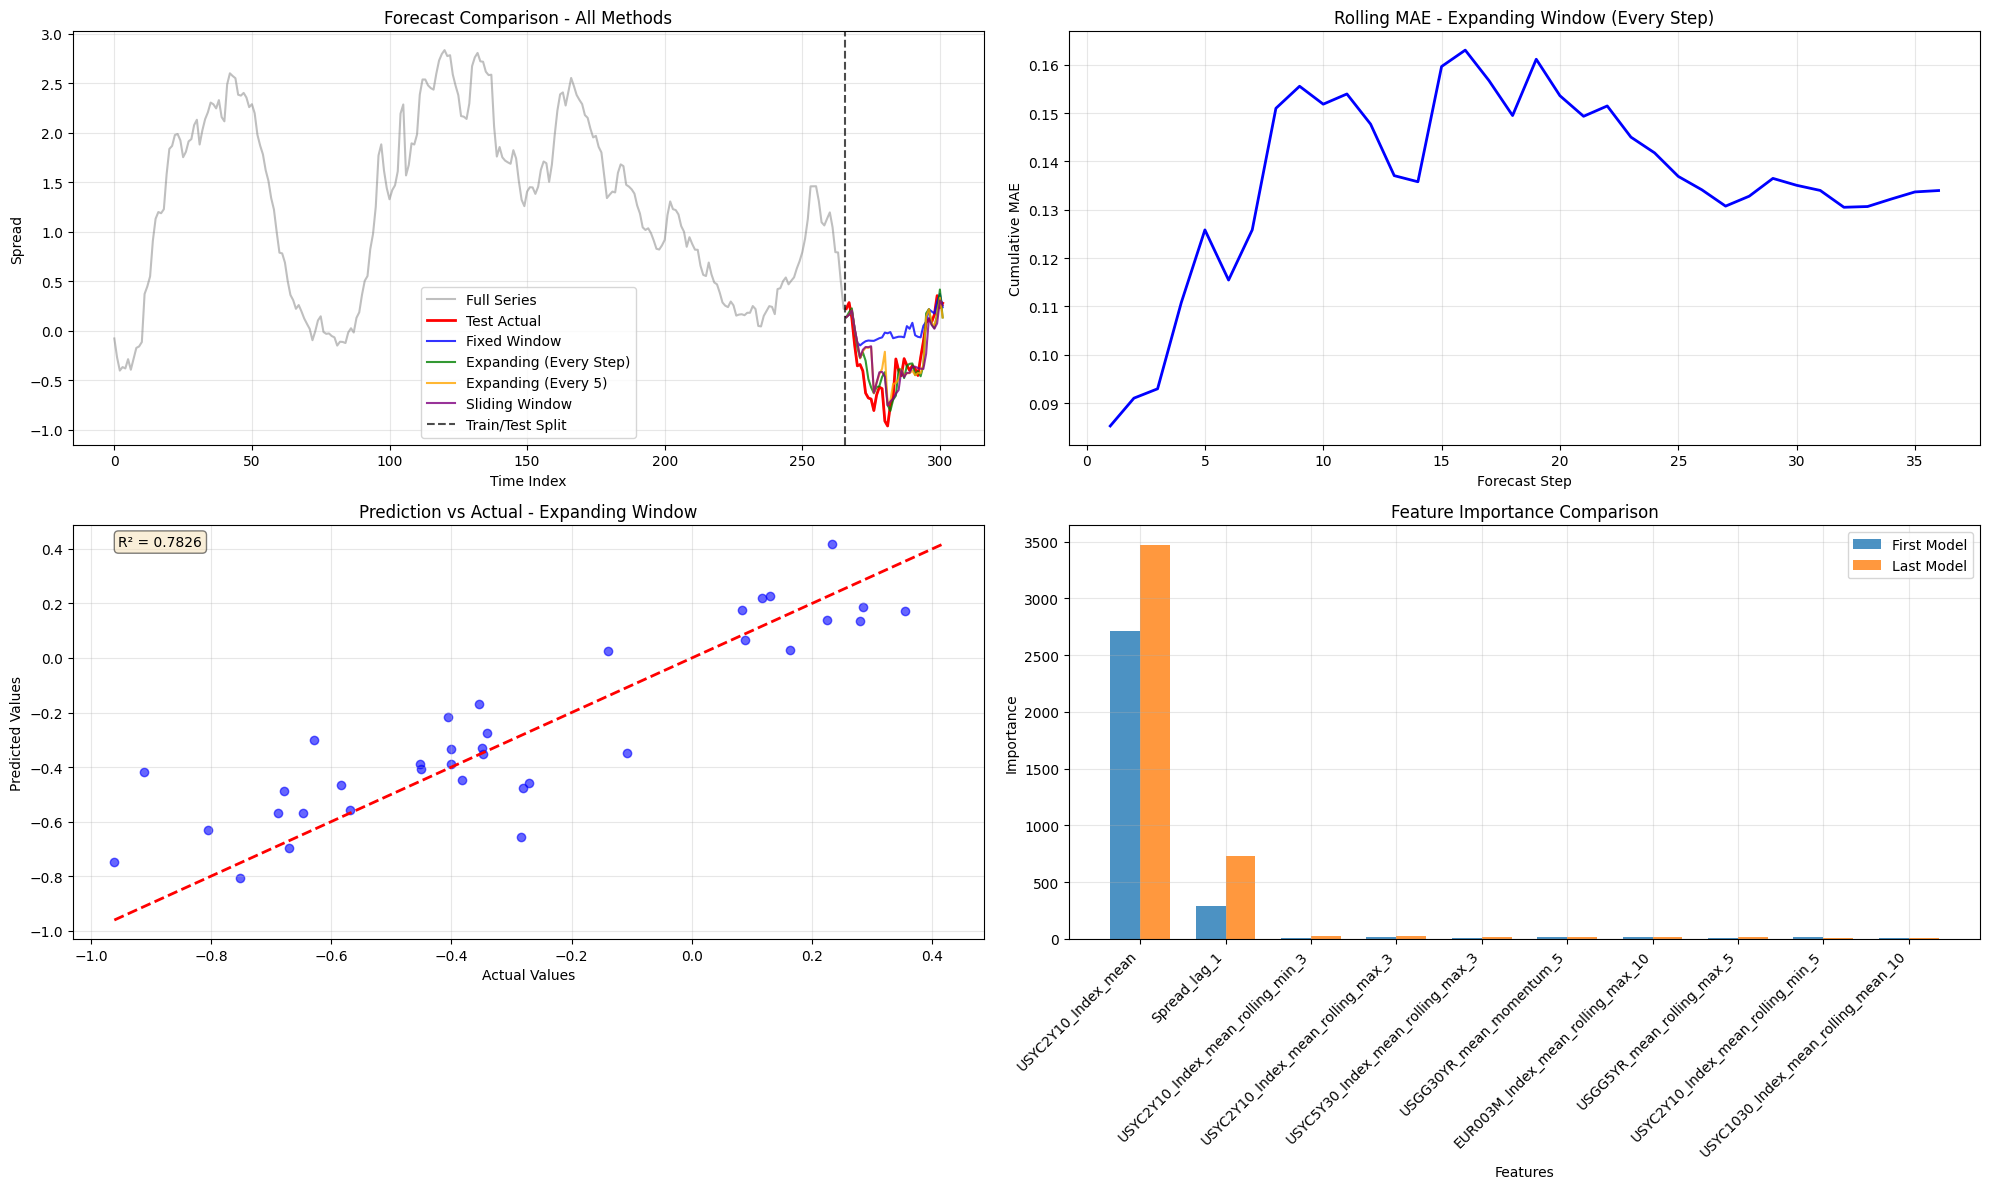


ROLLING ANALYSIS COMPLETED!
Results summary:
fixed_window: MAE = 0.340749
expanding_every_step: MAE = 0.133987
expanding_every_5: MAE = 0.169464
sliding_window: MAE = 0.168730


In [35]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def prepare_forecasting_data(feature_data, target_col='Spread', test_size=36, 
                           recommended_features=None, feature_selection_threshold=0.01):
    """
    Prepare data for LightGBM forecasting
    """
    print(f"Preparing data for forecasting...")
    print(f"Original feature data shape: {feature_data.shape}")
    
    # Remove rows where target is NaN
    clean_data = feature_data.dropna(subset=[target_col]).copy()
    print(f"After removing NaN targets: {clean_data.shape}")
    
    # Define feature columns
    if recommended_features is not None:
        # Use recommended features from analysis
        feature_cols = [col for col in recommended_features if col in clean_data.columns and col != target_col]
    else:
        # Use all numeric columns except target and lead features (for forecasting)
        feature_cols = [col for col in clean_data.columns 
                       if col != target_col 
                       and clean_data[col].dtype in ['float64', 'int64']
                       and not col.endswith('_lead_1')  # Exclude lead features for proper forecasting
                       and not col.endswith('_lead_2')
                       and not col.endswith('_lead_3')]
    
    print(f"Initial feature columns: {len(feature_cols)}")
    
    # Remove features with too many NaN values or constant values
    valid_features = []
    for col in feature_cols:
        # Check for sufficient non-NaN values
        non_nan_ratio = clean_data[col].notna().sum() / len(clean_data)
        # Check for sufficient variance
        if non_nan_ratio > 0.7 and clean_data[col].std() > feature_selection_threshold:
            valid_features.append(col)
        else:
            print(f"Removed {col}: NaN ratio = {1-non_nan_ratio:.3f}, Std = {clean_data[col].std():.6f}")
    
    print(f"Valid features after filtering: {len(valid_features)}")
    
    # Split train and test sets
    train_data = clean_data[:-test_size].copy()
    test_data = clean_data[-test_size:].copy()
    
    print(f"Train set shape: {train_data.shape}")
    print(f"Test set shape: {test_data.shape}")
    
    return train_data, test_data, valid_features, clean_data

def rolling_window_forecast(clean_data, valid_features, target_col='Spread', 
                          initial_train_size=None, test_size=36, 
                          retrain_frequency=1, cv_folds=3, random_state=42,
                          window_type='expanding'):
    """
    Perform rolling window forecasting with expanding or sliding window
    
    Parameters:
    -----------
    clean_data : DataFrame
        Complete dataset
    valid_features : list
        List of valid feature columns
    target_col : str
        Target column name
    initial_train_size : int
        Initial training set size (if None, uses all data except test_size)
    test_size : int
        Size of test set
    retrain_frequency : int
        How often to retrain the model (1 = every step, 5 = every 5 steps)
    cv_folds : int
        Number of CV folds for hyperparameter selection
    window_type : str
        'expanding' or 'sliding' window
    """
    
    print(f"\n{'='*80}")
    print(f"ROLLING WINDOW FORECASTING - {window_type.upper()} WINDOW")
    print(f"{'='*80}")
    
    total_size = len(clean_data)
    if initial_train_size is None:
        initial_train_size = total_size - test_size
    
    print(f"Total data size: {total_size}")
    print(f"Initial train size: {initial_train_size}")
    print(f"Test size: {test_size}")
    print(f"Retrain frequency: {retrain_frequency}")
    print(f"Window type: {window_type}")
    
    # Initialize results storage
    predictions = []
    actual_values = []
    mae_scores = []
    model_performances = []
    feature_importances = []
    
    # Get optimal parameters through initial CV
    print("\nDetermining optimal parameters through cross-validation...")
    initial_train_data = clean_data[:initial_train_size]
    optimal_params = get_optimal_lgb_params(
        initial_train_data, valid_features, target_col, cv_folds, random_state
    )
    
    print(f"Optimal parameters: {optimal_params}")
    
    # Rolling forecast loop
    model = None
    print(f"\nStarting rolling forecast...")
    
    for i in tqdm(range(test_size), desc="Rolling Forecast"):
        current_idx = initial_train_size + i
        
        # Define training window
        if window_type == 'expanding':
            # Expanding window: use all data from start to current point
            train_start_idx = 0
            train_end_idx = current_idx
        else:  # sliding window
            # Sliding window: use fixed-size window
            train_start_idx = max(0, current_idx - initial_train_size)
            train_end_idx = current_idx
        
        # Get training data for current window
        current_train_data = clean_data.iloc[train_start_idx:train_end_idx]
        
        # Prepare features and target
        X_train = current_train_data[valid_features].fillna(current_train_data[valid_features].mean())
        y_train = current_train_data[target_col]
        
        # Get current prediction point
        X_current = clean_data.iloc[current_idx:current_idx+1][valid_features].fillna(current_train_data[valid_features].mean())
        y_current = clean_data.iloc[current_idx][target_col]
        
        # Retrain model if needed
        if model is None or i % retrain_frequency == 0:
            print(f"\nRetraining model at step {i+1}/{test_size}")
            print(f"Training window: {train_start_idx} to {train_end_idx} (size: {len(current_train_data)})")
            
            # Create LightGBM dataset
            train_dataset = lgb.Dataset(X_train, label=y_train)
            
            # Train model with optimal parameters
            model = lgb.train(
                optimal_params,
                train_dataset,
                num_boost_round=optimal_params.get('num_boost_round', 500),
                callbacks=[lgb.log_evaluation(0)]
            )
            
            # Calculate training performance
            y_train_pred = model.predict(X_train)
            train_mae = mean_absolute_error(y_train, y_train_pred)
            train_r2 = r2_score(y_train, y_train_pred)
            
            model_performances.append({
                'step': i + 1,
                'train_size': len(current_train_data),
                'train_mae': train_mae,
                'train_r2': train_r2,
                'best_iteration': model.num_trees()
            })
            
            # Store feature importance
            if i == 0 or i == test_size - 1:  # Store for first and last model
                importance_df = pd.DataFrame({
                    'feature': valid_features,
                    'importance': model.feature_importance(importance_type='gain'),
                    'step': i + 1
                })
                feature_importances.append(importance_df)
        
        # Make prediction
        y_pred = model.predict(X_current)[0]
        
        # Store results
        predictions.append(y_pred)
        actual_values.append(y_current)
        
        # Calculate running MAE
        current_mae = mean_absolute_error(actual_values, predictions)
        mae_scores.append(current_mae)
        
        if (i + 1) % 10 == 0 or i == 0:
            print(f"Step {i+1}: Pred={y_pred:.6f}, Actual={y_current:.6f}, Running MAE={current_mae:.6f}")
    
    # Calculate final metrics
    final_mae = mean_absolute_error(actual_values, predictions)
    final_rmse = np.sqrt(mean_squared_error(actual_values, predictions))
    final_r2 = r2_score(actual_values, predictions)
    
    # Calculate directional accuracy
    actual_changes = np.diff(actual_values)
    pred_changes = np.diff(predictions)
    directional_accuracy = np.mean(np.sign(actual_changes) == np.sign(pred_changes))
    
    print(f"\n{'='*60}")
    print("ROLLING FORECAST RESULTS")
    print(f"{'='*60}")
    print(f"Final MAE: {final_mae:.6f}")
    print(f"Final RMSE: {final_rmse:.6f}")
    print(f"Final R²: {final_r2:.6f}")
    print(f"Directional Accuracy: {directional_accuracy:.4f}")
    print(f"Average Retrain Frequency: {len(model_performances)} retrains over {test_size} predictions")
    
    return {
        'predictions': predictions,
        'actual_values': actual_values,
        'mae_scores': mae_scores,
        'model_performances': model_performances,
        'feature_importances': feature_importances,
        'final_metrics': {
            'mae': final_mae,
            'rmse': final_rmse,
            'r2': final_r2,
            'directional_accuracy': directional_accuracy
        },
        'parameters': optimal_params
    }

def get_optimal_lgb_params(train_data, valid_features, target_col, cv_folds=3, random_state=42):
    """
    Get optimal LightGBM parameters through cross-validation
    """
    X_train = train_data[valid_features].fillna(train_data[valid_features].mean())
    y_train = train_data[target_col]
    
    # Parameter grid for tuning
    param_grids = [
        {
            'objective': 'regression',
            'metric': 'mae',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'random_state': random_state,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            'num_boost_round': 500
        },
        {
            'objective': 'regression',
            'metric': 'mae',
            'boosting_type': 'gbdt',
            'num_leaves': 50,
            'learning_rate': 0.03,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.9,
            'bagging_freq': 3,
            'verbose': -1,
            'random_state': random_state,
            'reg_alpha': 0.05,
            'reg_lambda': 0.05,
            'num_boost_round': 800
        }
    ]
    
    best_score = float('inf')
    best_params = param_grids[0]
    
    tscv = TimeSeriesSplit(n_splits=cv_folds)
    
    for params in param_grids:
        cv_scores = []
        
        for train_idx, val_idx in tscv.split(X_train):
            X_train_fold = X_train.iloc[train_idx]
            y_train_fold = y_train.iloc[train_idx]
            X_val_fold = X_train.iloc[val_idx]
            y_val_fold = y_train.iloc[val_idx]
            
            train_dataset = lgb.Dataset(X_train_fold, label=y_train_fold)
            val_dataset = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_dataset)
            
            model = lgb.train(
                params,
                train_dataset,
                valid_sets=[val_dataset],
                num_boost_round=params['num_boost_round'],
                callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
            )
            
            y_val_pred = model.predict(X_val_fold, num_iteration=model.best_iteration)
            cv_scores.append(mean_absolute_error(y_val_fold, y_val_pred))
        
        mean_cv_score = np.mean(cv_scores)
        if mean_cv_score < best_score:
            best_score = mean_cv_score
            best_params = params.copy()
    
    print(f"Best CV MAE: {best_score:.6f}")
    return best_params

def compare_forecast_methods(clean_data, valid_features, target_col='Spread', 
                           initial_train_size=None, test_size=36):
    """
    Compare different forecasting approaches
    """
    print(f"\n{'='*80}")
    print("COMPARING FORECAST METHODS")
    print(f"{'='*80}")
    
    methods_results = {}
    
    # 1. Fixed window (traditional approach)
    print("\n1. Fixed Window Approach...")
    train_data = clean_data[:-test_size]
    test_data = clean_data[-test_size:]
    
    X_train = train_data[valid_features].fillna(train_data[valid_features].mean())
    y_train = train_data[target_col]
    X_test = test_data[valid_features].fillna(train_data[valid_features].mean())
    y_test = test_data[target_col]
    
    # Get optimal parameters
    optimal_params = get_optimal_lgb_params(train_data, valid_features, target_col)
    
    # Train model
    train_dataset = lgb.Dataset(X_train, label=y_train)
    model = lgb.train(optimal_params, train_dataset, num_boost_round=optimal_params['num_boost_round'])
    
    # Predict
    y_pred_fixed = model.predict(X_test)
    
    methods_results['fixed_window'] = {
        'predictions': y_pred_fixed,
        'actual': y_test.values,
        'mae': mean_absolute_error(y_test, y_pred_fixed),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred_fixed)),
        'r2': r2_score(y_test, y_pred_fixed)
    }
    
    # 2. Expanding window (retrain every step)
    print("\n2. Expanding Window (retrain every step)...")
    expanding_results = rolling_window_forecast(
        clean_data, valid_features, target_col, initial_train_size, test_size,
        retrain_frequency=1, window_type='expanding'
    )
    methods_results['expanding_every_step'] = expanding_results
    
    # 3. Expanding window (retrain every 5 steps)
    print("\n3. Expanding Window (retrain every 5 steps)...")
    expanding_5_results = rolling_window_forecast(
        clean_data, valid_features, target_col, initial_train_size, test_size,
        retrain_frequency=5, window_type='expanding'
    )
    methods_results['expanding_every_5'] = expanding_5_results
    
    # 4. Sliding window
    print("\n4. Sliding Window...")
    sliding_results = rolling_window_forecast(
        clean_data, valid_features, target_col, initial_train_size, test_size,
        retrain_frequency=5, window_type='sliding'
    )
    methods_results['sliding_window'] = sliding_results
    
    # Compare results
    print(f"\n{'='*80}")
    print("METHOD COMPARISON")
    print(f"{'='*80}")
    print(f"{'Method':<25} {'MAE':<12} {'RMSE':<12} {'R²':<10} {'Dir_Acc':<10}")
    print(f"{'-'*70}")
    
    for method_name, results in methods_results.items():
        if method_name == 'fixed_window':
            mae = results['mae']
            rmse = results['rmse']
            r2 = results['r2']
            # Calculate directional accuracy for fixed window
            actual_changes = np.diff(results['actual'])
            pred_changes = np.diff(results['predictions'])
            dir_acc = np.mean(np.sign(actual_changes) == np.sign(pred_changes))
        else:
            mae = results['final_metrics']['mae']
            rmse = results['final_metrics']['rmse']
            r2 = results['final_metrics']['r2']
            dir_acc = results['final_metrics']['directional_accuracy']
        
        print(f"{method_name:<25} {mae:<12.6f} {rmse:<12.6f} {r2:<10.4f} {dir_acc:<10.4f}")
    
    return methods_results

def plot_rolling_forecast_results(results_dict, clean_data, target_col='Spread', test_size=36):
    """
    Plot comprehensive rolling forecast results
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # Extract data for plotting
    total_size = len(clean_data)
    train_size = total_size - test_size
    
    # Plot 1: Forecast comparison
    ax1 = axes[0, 0]
    test_indices = range(train_size, total_size)
    actual_test = clean_data[target_col].iloc[-test_size:].values
    
    # Plot actual values
    ax1.plot(range(total_size), clean_data[target_col], label='Full Series', color='gray', alpha=0.5)
    ax1.plot(test_indices, actual_test, label='Test Actual', color='red', linewidth=2)
    
    # Plot predictions from different methods
    colors = ['blue', 'green', 'orange', 'purple']
    method_names = ['Fixed Window', 'Expanding (Every Step)', 'Expanding (Every 5)', 'Sliding Window']
    
    for i, (method_key, method_name) in enumerate(zip(['fixed_window', 'expanding_every_step', 
                                                      'expanding_every_5', 'sliding_window'], method_names)):
        if method_key in results_dict:
            if method_key == 'fixed_window':
                predictions = results_dict[method_key]['predictions']
            else:
                predictions = results_dict[method_key]['predictions']
            
            ax1.plot(test_indices, predictions, label=f'{method_name}', 
                    color=colors[i], linewidth=1.5, alpha=0.8)
    
    ax1.axvline(x=train_size-0.5, color='black', linestyle='--', alpha=0.7, label='Train/Test Split')
    ax1.set_title('Forecast Comparison - All Methods')
    ax1.set_xlabel('Time Index')
    ax1.set_ylabel(target_col)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Rolling MAE for expanding window
    ax2 = axes[0, 1]
    if 'expanding_every_step' in results_dict:
        mae_scores = results_dict['expanding_every_step']['mae_scores']
        ax2.plot(range(1, len(mae_scores) + 1), mae_scores, color='blue', linewidth=2)
        ax2.set_title('Rolling MAE - Expanding Window (Every Step)')
        ax2.set_xlabel('Forecast Step')
        ax2.set_ylabel('Cumulative MAE')
        ax2.grid(True, alpha=0.3)
    
    # Plot 3: Prediction vs Actual scatter
    ax3 = axes[1, 0]
    if 'expanding_every_step' in results_dict:
        predictions = results_dict['expanding_every_step']['predictions']
        actual = results_dict['expanding_every_step']['actual_values']
        
        ax3.scatter(actual, predictions, alpha=0.6, color='blue')
        min_val = min(min(actual), min(predictions))
        max_val = max(max(actual), max(predictions))
        ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        ax3.set_xlabel('Actual Values')
        ax3.set_ylabel('Predicted Values')
        ax3.set_title('Prediction vs Actual - Expanding Window')
        ax3.grid(True, alpha=0.3)
        
        # Add R² to the plot
        r2 = results_dict['expanding_every_step']['final_metrics']['r2']
        ax3.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax3.transAxes, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 4: Feature importance comparison
    ax4 = axes[1, 1]
    if 'expanding_every_step' in results_dict and results_dict['expanding_every_step']['feature_importances']:
        # Plot feature importance from first and last model
        feature_imp_data = results_dict['expanding_every_step']['feature_importances']
        
        if len(feature_imp_data) > 1:
            first_imp = feature_imp_data[0].set_index('feature')['importance']
            last_imp = feature_imp_data[-1].set_index('feature')['importance']
            
            # Get top features
            top_features = last_imp.nlargest(10).index
            
            x_pos = np.arange(len(top_features))
            width = 0.35
            
            ax4.bar(x_pos - width/2, first_imp[top_features], width, label='First Model', alpha=0.8)
            ax4.bar(x_pos + width/2, last_imp[top_features], width, label='Last Model', alpha=0.8)
            
            ax4.set_xlabel('Features')
            ax4.set_ylabel('Importance')
            ax4.set_title('Feature Importance Comparison')
            ax4.set_xticks(x_pos)
            ax4.set_xticklabels(top_features, rotation=45, ha='right')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def run_complete_rolling_analysis(feature_data, target_col='Spread', test_size=36, 
                                recommended_features=None):
    """
    Run complete rolling window analysis
    """
    print("="*100)
    print("COMPLETE ROLLING WINDOW FORECASTING ANALYSIS")
    print("="*100)
    
    # Prepare data
    train_data, test_data, valid_features, clean_data = prepare_forecasting_data(
        feature_data, target_col, test_size, recommended_features
    )
    
    if len(valid_features) == 0:
        print("ERROR: No valid features found for modeling!")
        return None
    
    # Compare all forecast methods
    comparison_results = compare_forecast_methods(
        clean_data, valid_features, target_col, None, test_size
    )
    
    # Plot comprehensive results
    plot_rolling_forecast_results(comparison_results, clean_data, target_col, test_size)
    
    return {
        'clean_data': clean_data,
        'valid_features': valid_features,
        'comparison_results': comparison_results
    }

# Example usage:
if 'analysis_results' in locals():
    # Use the feature data and recommendations from your analysis
    rolling_results = run_complete_rolling_analysis(
        feature_data=analysis_results['feature_data'],
        target_col='Spread',
        test_size=36,
        recommended_features=analysis_results['recommended_features'][:50]  # Use top 50 features
    )
    
    print("\n" + "="*80)
    print("ROLLING ANALYSIS COMPLETED!")
    print("="*80)
    
    if rolling_results:
        print("Results summary:")
        for method, results in rolling_results['comparison_results'].items():
            if method == 'fixed_window':
                mae = results['mae']
            else:
                mae = results['final_metrics']['mae']
            print(f"{method}: MAE = {mae:.6f}")

elif 'feature_data' in locals():
    # If you have feature_data directly
    rolling_results = run_complete_rolling_analysis(
        feature_data=feature_data,
        target_col='Spread',
        test_size=36
    )

else:
    print("Please ensure you have either 'analysis_results' or 'feature_data' available.")
    print("Run the feature engineering code first, then execute this rolling analysis.")

In [37]:
feature_data = create_lead_lag_features(
    data, 
    target_col='Spread', 
    other_cols=other_features,
    max_lags=5, 
    max_leads=2
)

Creating lag features for Spread...
Creating features for USGG2YR_mean...
Creating features for USGG5YR_mean...
Creating features for USGG10YR_mean...
Creating features for USGG30YR_mean...
Creating features for FEDL01_Index_mean...
Creating features for VIX_Index_mean...
Creating features for MOVE_Index_mean...
Creating features for USGG5Y5Y_Index_mean...
Creating features for USYC5Y30_Index_mean...
Creating features for USYC1030_Index_mean...
Creating features for USYC2Y10_Index_mean...
Creating features for USDCNY_Curncy_mean...
Creating features for EUR_Curncy_mean...
Creating features for EUR003M_Index_mean...
Creating features for GDBR10_Index_mean...
Creating features for CO1_Comdty_mean...
Creating features for USDCHF_BGN_Curncy_mean...
Creating features for TBSM6M_Index_mean...


In [38]:
clean_data = feature_data.dropna(subset=['Spread']).copy()

In [39]:
recommended_features=analysis_results['recommended_features'][:50]

In [40]:
train_data, test_data, valid_features, clean_data = prepare_forecasting_data(
    feature_data, 'Spread', test_size, recommended_features
)

Preparing data for forecasting...
Original feature data shape: (302, 421)
After removing NaN targets: (302, 421)
Initial feature columns: 20
Valid features after filtering: 20
Train set shape: (266, 421)
Test set shape: (36, 421)


In [41]:
comparison_results = compare_forecast_methods(
    clean_data, valid_features, 'Spread', None, test_size
)


COMPARING FORECAST METHODS

1. Fixed Window Approach...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 0.407788
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's l1: 0.191944
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's l1: 0.101077
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[132]	valid_0's l1: 0.388147
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 0.187902
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	valid_0's l1: 0.105215
Best CV MAE: 0.227088

2. Expanding Window (retrain every step)...

ROLLING WINDOW FORECASTING - EXPANDING WINDOW
Total data size: 302
Initial train size: 266
Test size: 36
Retrain frequency: 1
Wind

Rolling Forecast:   0%|          | 0/36 [00:00<?, ?it/s]


Retraining model at step 1/36
Training window: 0 to 266 (size: 266)


Rolling Forecast:   3%|▎         | 1/36 [00:00<00:17,  1.98it/s]

Step 1: Pred=0.138909, Actual=0.224190, Running MAE=0.085282

Retraining model at step 2/36
Training window: 0 to 267 (size: 267)


Rolling Forecast:   6%|▌         | 2/36 [00:00<00:13,  2.62it/s]


Retraining model at step 3/36
Training window: 0 to 268 (size: 268)


Rolling Forecast:   8%|▊         | 3/36 [00:01<00:12,  2.72it/s]


Retraining model at step 4/36
Training window: 0 to 269 (size: 269)


Rolling Forecast:  11%|█         | 4/36 [00:01<00:14,  2.27it/s]


Retraining model at step 5/36
Training window: 0 to 270 (size: 270)


Rolling Forecast:  14%|█▍        | 5/36 [00:02<00:13,  2.33it/s]


Retraining model at step 6/36
Training window: 0 to 271 (size: 271)


Rolling Forecast:  17%|█▋        | 6/36 [00:02<00:13,  2.19it/s]


Retraining model at step 7/36
Training window: 0 to 272 (size: 272)


Rolling Forecast:  19%|█▉        | 7/36 [00:02<00:12,  2.36it/s]


Retraining model at step 8/36
Training window: 0 to 273 (size: 273)


Rolling Forecast:  22%|██▏       | 8/36 [00:03<00:11,  2.36it/s]


Retraining model at step 9/36
Training window: 0 to 274 (size: 274)


Rolling Forecast:  25%|██▌       | 9/36 [00:04<00:14,  1.92it/s]


Retraining model at step 10/36
Training window: 0 to 275 (size: 275)


Rolling Forecast:  28%|██▊       | 10/36 [00:04<00:12,  2.14it/s]

Step 10: Pred=-0.570425, Actual=-0.688914, Running MAE=0.151858

Retraining model at step 11/36
Training window: 0 to 276 (size: 276)


Rolling Forecast:  31%|███       | 11/36 [00:04<00:10,  2.31it/s]


Retraining model at step 12/36
Training window: 0 to 277 (size: 277)


Rolling Forecast:  33%|███▎      | 12/36 [00:05<00:09,  2.49it/s]


Retraining model at step 13/36
Training window: 0 to 278 (size: 278)


Rolling Forecast:  36%|███▌      | 13/36 [00:05<00:08,  2.62it/s]


Retraining model at step 14/36
Training window: 0 to 279 (size: 279)


Rolling Forecast:  39%|███▉      | 14/36 [00:05<00:08,  2.70it/s]


Retraining model at step 15/36
Training window: 0 to 280 (size: 280)


Rolling Forecast:  42%|████▏     | 15/36 [00:06<00:07,  2.71it/s]


Retraining model at step 16/36
Training window: 0 to 281 (size: 281)


Rolling Forecast:  44%|████▍     | 16/36 [00:06<00:08,  2.47it/s]


Retraining model at step 17/36
Training window: 0 to 282 (size: 282)


Rolling Forecast:  47%|████▋     | 17/36 [00:07<00:07,  2.53it/s]


Retraining model at step 18/36
Training window: 0 to 283 (size: 283)


Rolling Forecast:  50%|█████     | 18/36 [00:07<00:06,  2.69it/s]


Retraining model at step 19/36
Training window: 0 to 284 (size: 284)


Rolling Forecast:  53%|█████▎    | 19/36 [00:07<00:06,  2.70it/s]


Retraining model at step 20/36
Training window: 0 to 285 (size: 285)


Rolling Forecast:  56%|█████▌    | 20/36 [00:08<00:05,  2.76it/s]

Step 20: Pred=-0.390285, Actual=-0.400600, Running MAE=0.153610

Retraining model at step 21/36
Training window: 0 to 286 (size: 286)


Rolling Forecast:  58%|█████▊    | 21/36 [00:08<00:04,  3.01it/s]


Retraining model at step 22/36
Training window: 0 to 287 (size: 287)


Rolling Forecast:  61%|██████    | 22/36 [00:08<00:04,  2.89it/s]


Retraining model at step 23/36
Training window: 0 to 288 (size: 288)


Rolling Forecast:  64%|██████▍   | 23/36 [00:09<00:04,  2.92it/s]


Retraining model at step 24/36
Training window: 0 to 289 (size: 289)


Rolling Forecast:  67%|██████▋   | 24/36 [00:09<00:04,  2.95it/s]


Retraining model at step 25/36
Training window: 0 to 290 (size: 290)


Rolling Forecast:  69%|██████▉   | 25/36 [00:09<00:03,  2.88it/s]


Retraining model at step 26/36
Training window: 0 to 291 (size: 291)


Rolling Forecast:  72%|███████▏  | 26/36 [00:10<00:03,  2.93it/s]


Retraining model at step 27/36
Training window: 0 to 292 (size: 292)


Rolling Forecast:  75%|███████▌  | 27/36 [00:10<00:03,  2.90it/s]


Retraining model at step 28/36
Training window: 0 to 293 (size: 293)


Rolling Forecast:  78%|███████▊  | 28/36 [00:10<00:02,  2.86it/s]


Retraining model at step 29/36
Training window: 0 to 294 (size: 294)


Rolling Forecast:  81%|████████  | 29/36 [00:11<00:02,  3.04it/s]


Retraining model at step 30/36
Training window: 0 to 295 (size: 295)


Rolling Forecast:  83%|████████▎ | 30/36 [00:11<00:02,  2.87it/s]

Step 30: Pred=0.177010, Actual=0.083324, Running MAE=0.135076

Retraining model at step 31/36
Training window: 0 to 296 (size: 296)


Rolling Forecast:  86%|████████▌ | 31/36 [00:11<00:01,  2.82it/s]


Retraining model at step 32/36
Training window: 0 to 297 (size: 297)


Rolling Forecast:  89%|████████▉ | 32/36 [00:12<00:01,  2.76it/s]


Retraining model at step 33/36
Training window: 0 to 298 (size: 298)


Rolling Forecast:  92%|█████████▏| 33/36 [00:12<00:01,  2.69it/s]


Retraining model at step 34/36
Training window: 0 to 299 (size: 299)


Rolling Forecast:  94%|█████████▍| 34/36 [00:13<00:00,  2.57it/s]


Retraining model at step 35/36
Training window: 0 to 300 (size: 300)


Rolling Forecast:  97%|█████████▋| 35/36 [00:13<00:00,  2.05it/s]


Retraining model at step 36/36
Training window: 0 to 301 (size: 301)


Rolling Forecast: 100%|██████████| 36/36 [00:14<00:00,  2.54it/s]



ROLLING FORECAST RESULTS
Final MAE: 0.133987
Final RMSE: 0.169933
Final R²: 0.782631
Directional Accuracy: 0.5429
Average Retrain Frequency: 36 retrains over 36 predictions

3. Expanding Window (retrain every 5 steps)...

ROLLING WINDOW FORECASTING - EXPANDING WINDOW
Total data size: 302
Initial train size: 266
Test size: 36
Retrain frequency: 5
Window type: expanding

Determining optimal parameters through cross-validation...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 0.407788
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's l1: 0.191944
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's l1: 0.101077
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[132]	valid_0's l1: 0.388147
Training until validation scores don't improve for 50 rounds
Early stop

Rolling Forecast:   0%|          | 0/36 [00:00<?, ?it/s]


Retraining model at step 1/36
Training window: 0 to 266 (size: 266)


Rolling Forecast:   3%|▎         | 1/36 [00:00<00:12,  2.74it/s]

Step 1: Pred=0.138909, Actual=0.224190, Running MAE=0.085282

Retraining model at step 6/36
Training window: 0 to 271 (size: 271)


Rolling Forecast:  17%|█▋        | 6/36 [00:00<00:03,  8.83it/s]

Step 10: Pred=-0.162968, Actual=-0.688914, Running MAE=0.243506

Retraining model at step 11/36
Training window: 0 to 276 (size: 276)


Rolling Forecast:  31%|███       | 11/36 [00:01<00:02,  9.33it/s]


Retraining model at step 16/36
Training window: 0 to 281 (size: 281)


Rolling Forecast:  44%|████▍     | 16/36 [00:01<00:02,  9.90it/s]

Step 20: Pred=-0.492805, Actual=-0.400600, Running MAE=0.224507

Retraining model at step 21/36
Training window: 0 to 286 (size: 286)


Rolling Forecast:  58%|█████▊    | 21/36 [00:02<00:01, 11.58it/s]


Retraining model at step 26/36
Training window: 0 to 291 (size: 291)


Rolling Forecast:  72%|███████▏  | 26/36 [00:02<00:00, 12.52it/s]

Step 30: Pred=0.140521, Actual=0.083324, Running MAE=0.180841

Retraining model at step 31/36
Training window: 0 to 296 (size: 296)


Rolling Forecast:  86%|████████▌ | 31/36 [00:02<00:00, 11.28it/s]


Retraining model at step 36/36
Training window: 0 to 301 (size: 301)


Rolling Forecast: 100%|██████████| 36/36 [00:03<00:00, 11.08it/s]



ROLLING FORECAST RESULTS
Final MAE: 0.169464
Final RMSE: 0.226797
Final R²: 0.612814
Directional Accuracy: 0.5143
Average Retrain Frequency: 8 retrains over 36 predictions

4. Sliding Window...

ROLLING WINDOW FORECASTING - SLIDING WINDOW
Total data size: 302
Initial train size: 266
Test size: 36
Retrain frequency: 5
Window type: sliding

Determining optimal parameters through cross-validation...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 0.407788
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's l1: 0.191944
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's l1: 0.101077
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[132]	valid_0's l1: 0.388147
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	v

Rolling Forecast:   0%|          | 0/36 [00:00<?, ?it/s]


Retraining model at step 1/36
Training window: 0 to 266 (size: 266)


Rolling Forecast:   3%|▎         | 1/36 [00:00<00:12,  2.86it/s]

Step 1: Pred=0.138909, Actual=0.224190, Running MAE=0.085282

Retraining model at step 6/36
Training window: 5 to 271 (size: 266)


Rolling Forecast:  17%|█▋        | 6/36 [00:00<00:02, 10.89it/s]

Step 10: Pred=-0.155400, Actual=-0.688914, Running MAE=0.247916

Retraining model at step 11/36
Training window: 10 to 276 (size: 266)


Rolling Forecast:  36%|███▌      | 13/36 [00:01<00:01, 14.89it/s]


Retraining model at step 16/36
Training window: 15 to 281 (size: 266)


Rolling Forecast:  44%|████▍     | 16/36 [00:01<00:02,  9.94it/s]

Step 20: Pred=-0.598168, Actual=-0.400600, Running MAE=0.217918

Retraining model at step 21/36
Training window: 20 to 286 (size: 266)


Rolling Forecast:  72%|███████▏  | 26/36 [00:02<00:00, 14.69it/s]


Retraining model at step 26/36
Training window: 25 to 291 (size: 266)


Rolling Forecast:  86%|████████▌ | 31/36 [00:02<00:00, 16.29it/s]

Step 30: Pred=-0.231541, Actual=0.083324, Running MAE=0.183841

Retraining model at step 31/36
Training window: 30 to 296 (size: 266)


Rolling Forecast: 100%|██████████| 36/36 [00:02<00:00, 14.18it/s]


Retraining model at step 36/36
Training window: 35 to 301 (size: 266)

ROLLING FORECAST RESULTS
Final MAE: 0.168730
Final RMSE: 0.222056
Final R²: 0.628834
Directional Accuracy: 0.5143
Average Retrain Frequency: 8 retrains over 36 predictions

METHOD COMPARISON
Method                    MAE          RMSE         R²         Dir_Acc   
----------------------------------------------------------------------
fixed_window              0.340749     0.419950     -0.3275    0.5429    
expanding_every_step      0.133987     0.169933     0.7826     0.5429    
expanding_every_5         0.169464     0.226797     0.6128     0.5143    
sliding_window            0.168730     0.222056     0.6288     0.5143    


In [42]:
target_col = 'Spread'

In [45]:
results_dict = comparison_results

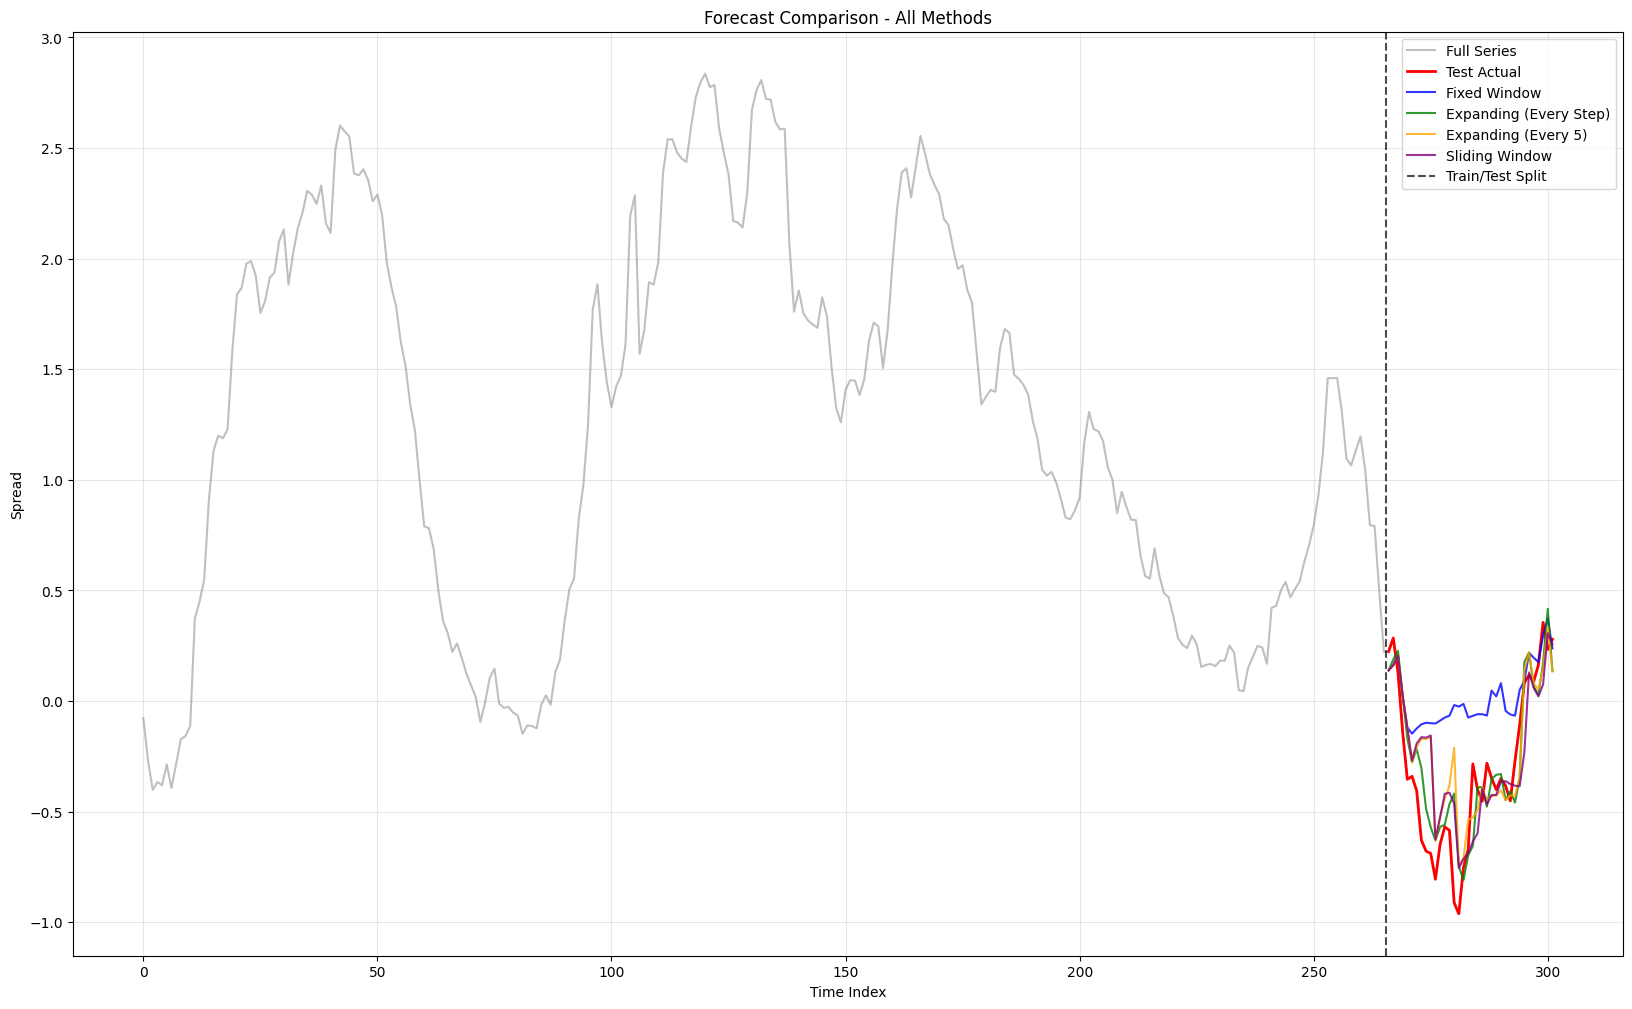

In [49]:
import matplotlib.pyplot as plt

"""
Plot comprehensive rolling forecast results (Single Plot)
"""
plt.figure(figsize=(20, 12))
ax = plt.gca()  # get current axes

# Extract data for plotting
total_size = len(clean_data)
train_size = total_size - test_size

# Plot actual values
test_indices = range(train_size, total_size)
actual_test = clean_data[target_col].iloc[-test_size:].values

ax.plot(range(total_size), clean_data[target_col], label='Full Series', color='gray', alpha=0.5)
ax.plot(test_indices, actual_test, label='Test Actual', color='red', linewidth=2)

# Plot predictions from different methods
colors = ['blue', 'green', 'orange', 'purple']
method_names = ['Fixed Window', 'Expanding (Every Step)', 'Expanding (Every 5)', 'Sliding Window']

for i, (method_key, method_name) in enumerate(zip(
    ['fixed_window', 'expanding_every_step', 'expanding_every_5', 'sliding_window'], 
    method_names)):
    
    if method_key in results_dict:
        predictions = results_dict[method_key]['predictions']
        ax.plot(test_indices, predictions, label=f'{method_name}', 
                color=colors[i], linewidth=1.5, alpha=0.8)

# Add train-test split line
ax.axvline(x=train_size - 0.5, color='black', linestyle='--', alpha=0.7, label='Train/Test Split')

# Add labels and grid
ax.set_title('Forecast Comparison - All Methods')
ax.set_xlabel('Time Index')
ax.set_ylabel(target_col)
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()


# XGBoost Model

XGBOOST TIME SERIES FORECASTING
Original data shape: (302, 20)
Target column: Spread
Test size: 36

1. Creating Features...
Creating features for columns: ['USGG2YR_mean', 'USGG5YR_mean', 'USGG10YR_mean', 'USGG30YR_mean', 'FEDL01_Index_mean', 'VIX_Index_mean', 'MOVE_Index_mean', 'USGG5Y5Y_Index_mean', 'USYC5Y30_Index_mean', 'USYC1030_Index_mean', 'USYC2Y10_Index_mean', 'USDCNY_Curncy_mean', 'EUR_Curncy_mean', 'EUR003M_Index_mean', 'GDBR10_Index_mean', 'CO1_Comdty_mean', 'USDCHF_BGN_Curncy_mean', 'TBSM6M_Index_mean']
Shape after feature engineering: (302, 799)

2. Selecting Features...
Features passing correlation filter: 561
Features selected after MI filtering: 113
Selected 113 features

3. Preparing Data...
Train data shape: (266, 799)
Test data shape: (36, 799)
Final feature count: 113

Performing 5-fold time series cross-validation...
Fold 1: MAE = 0.2060, RMSE = 0.3209, R² = 0.8652
Fold 2: MAE = 0.5094, RMSE = 0.5778, R² = 0.2667
Fold 3: MAE = 0.2918, RMSE = 0.3812, R² = 0.1029
Fo

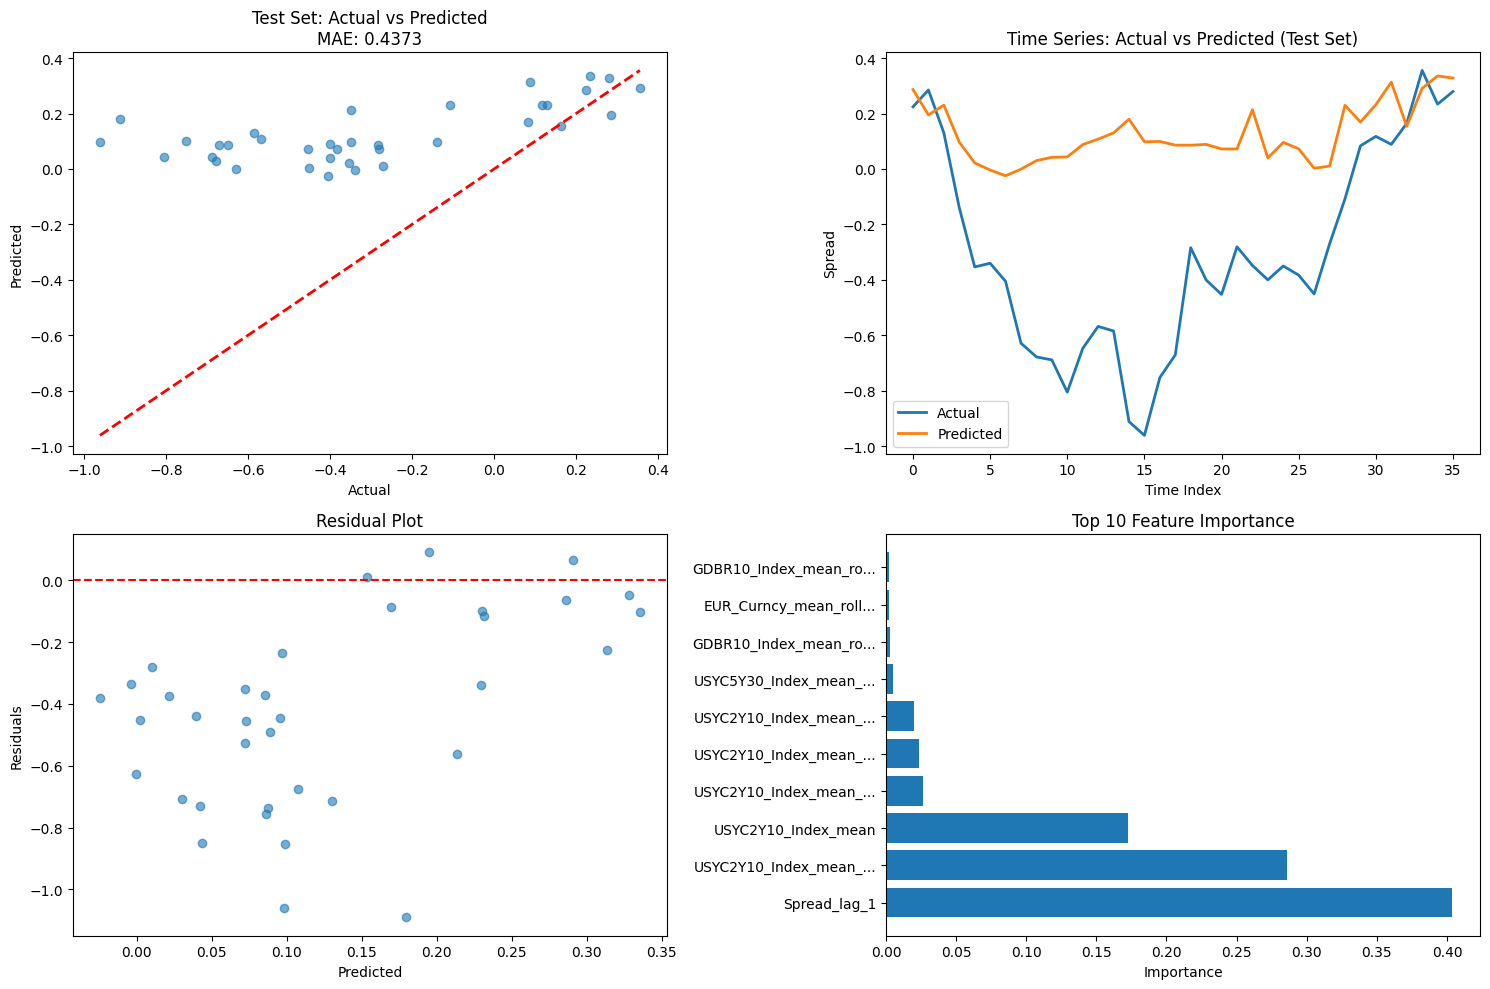

Cross-validation MAE: 0.2718 ± 0.1262
Test MAE: 0.4373

Top 10 Features:
                                feature  importance
4                          Spread_lag_1    0.403374
69   USYC2Y10_Index_mean_rolling_mean_3    0.285715
2                   USYC2Y10_Index_mean    0.172810
65            USYC2Y10_Index_mean_lag_1    0.026727
70    USYC2Y10_Index_mean_rolling_min_3    0.023431
71    USYC2Y10_Index_mean_rolling_max_3    0.020126
31    USYC5Y30_Index_mean_rolling_max_3    0.005003
102    GDBR10_Index_mean_rolling_q75_10    0.002865
87      EUR_Curncy_mean_rolling_mean_20    0.002451
94     GDBR10_Index_mean_rolling_mean_5    0.002235


In [51]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

class XGBoostTimeSeriesForecaster:
    def __init__(self, target_col='Spread', test_size=36, cv_folds=5):
        self.target_col = target_col
        self.test_size = test_size
        self.cv_folds = cv_folds
        self.model = None
        self.scaler = None
        self.feature_names = None
        self.results = {}
        
    def create_lead_lag_features(self, df, other_cols=None, max_lags=5):
        """Create lag features and technical indicators"""
        feature_df = df.copy()
        
        # If no other columns specified, use all numeric columns except target
        if other_cols is None:
            other_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                         if col != self.target_col]
        
        print(f"Creating features for columns: {other_cols}")
        
        # Create lag features for target variable
        for lag in range(1, max_lags + 1):
            feature_df[f'{self.target_col}_lag_{lag}'] = feature_df[self.target_col].shift(lag)
        
        # Create features for other variables
        for col in other_cols:
            # Lag features
            for lag in range(1, max_lags + 1):
                feature_df[f'{col}_lag_{lag}'] = feature_df[col].shift(lag)
            
            # Rolling statistics
            for window in [3, 5, 10, 20]:
                feature_df[f'{col}_rolling_mean_{window}'] = feature_df[col].rolling(window).mean()
                feature_df[f'{col}_rolling_std_{window}'] = feature_df[col].rolling(window).std()
                feature_df[f'{col}_rolling_min_{window}'] = feature_df[col].rolling(window).min()
                feature_df[f'{col}_rolling_max_{window}'] = feature_df[col].rolling(window).max()
                
                # Rolling quantiles
                feature_df[f'{col}_rolling_q25_{window}'] = feature_df[col].rolling(window).quantile(0.25)
                feature_df[f'{col}_rolling_q75_{window}'] = feature_df[col].rolling(window).quantile(0.75)
            
            # Differencing features
            feature_df[f'{col}_diff_1'] = feature_df[col].diff(1)
            feature_df[f'{col}_diff_2'] = feature_df[col].diff(2)
            
            # Percentage change
            feature_df[f'{col}_pct_change'] = feature_df[col].pct_change()
            feature_df[f'{col}_pct_change_2'] = feature_df[col].pct_change(periods=2)
            
            # Momentum features
            for period in [3, 5, 10]:
                feature_df[f'{col}_momentum_{period}'] = feature_df[col] - feature_df[col].shift(period)
                feature_df[f'{col}_roc_{period}'] = (feature_df[col] / feature_df[col].shift(period) - 1) * 100
            
            # Volatility features
            feature_df[f'{col}_volatility_5'] = feature_df[col].rolling(5).std()
            feature_df[f'{col}_volatility_10'] = feature_df[col].rolling(10).std()
            
            # Technical indicators
            # RSI approximation
            delta = feature_df[col].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / loss
            feature_df[f'{col}_rsi'] = 100 - (100 / (1 + rs))
            
            # Bollinger Bands position
            sma_20 = feature_df[col].rolling(20).mean()
            std_20 = feature_df[col].rolling(20).std()
            feature_df[f'{col}_bb_position'] = (feature_df[col] - sma_20) / (2 * std_20)
        
        return feature_df
    
    def select_features(self, df, correlation_threshold=0.05, mutual_info_percentile=80):
        """Select features based on correlation and mutual information"""
        feature_cols = [col for col in df.columns if col != self.target_col and 
                       df[col].dtype in ['float64', 'int64']]
        
        # Remove rows with NaN in target
        clean_df = df.dropna(subset=[self.target_col])
        
        # Calculate correlations
        correlations = []
        for col in feature_cols:
            clean_data = clean_df[[self.target_col, col]].dropna()
            if len(clean_data) > 20:
                corr, p_val = pearsonr(clean_data[self.target_col], clean_data[col])
                correlations.append({
                    'feature': col,
                    'correlation': abs(corr),
                    'p_value': p_val
                })
        
        # Filter by correlation significance
        corr_df = pd.DataFrame(correlations)
        significant_features = corr_df[
            (corr_df['correlation'] > correlation_threshold) & 
            (corr_df['p_value'] < 0.05)
        ]['feature'].tolist()
        
        print(f"Features passing correlation filter: {len(significant_features)}")
        
        if len(significant_features) > 0:
            # Calculate mutual information for significant features
            X = clean_df[significant_features].fillna(clean_df[significant_features].mean())
            y = clean_df[self.target_col]
            
            mi_scores = mutual_info_regression(X, y, random_state=42)
            mi_threshold = np.percentile(mi_scores, mutual_info_percentile)
            
            # Select features above MI threshold
            selected_features = [feat for feat, score in zip(significant_features, mi_scores) 
                               if score >= mi_threshold]
            
            print(f"Features selected after MI filtering: {len(selected_features)}")
            return selected_features
        else:
            print("No features passed correlation filter, using top features by absolute correlation")
            return corr_df.nlargest(20, 'correlation')['feature'].tolist()
    
    def time_series_cross_validation(self, X, y):
        """Perform time series cross-validation"""
        tscv = TimeSeriesSplit(n_splits=self.cv_folds)
        cv_scores = []
        fold_details = []
        
        print(f"\nPerforming {self.cv_folds}-fold time series cross-validation...")
        
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
            
            # Train model for this fold
            model = xgb.XGBRegressor(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1
            )
            
            model.fit(X_train_fold, y_train_fold)
            y_pred_fold = model.predict(X_val_fold)
            
            # Calculate metrics
            mae = mean_absolute_error(y_val_fold, y_pred_fold)
            mse = mean_squared_error(y_val_fold, y_pred_fold)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_val_fold, y_pred_fold)
            
            cv_scores.append(mae)
            fold_details.append({
                'fold': fold + 1,
                'train_size': len(train_idx),
                'val_size': len(val_idx),
                'mae': mae,
                'rmse': rmse,
                'r2': r2
            })
            
            print(f"Fold {fold + 1}: MAE = {mae:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}")
        
        cv_mean = np.mean(cv_scores)
        cv_std = np.std(cv_scores)
        
        print(f"\nCross-Validation Results:")
        print(f"Mean MAE: {cv_mean:.4f} ± {cv_std:.4f}")
        
        return cv_scores, fold_details, cv_mean, cv_std
    
    def fit_and_evaluate(self, data, other_features=None, xgb_params=None):
        """Main method to fit XGBoost model and evaluate performance"""
        
        print("="*80)
        print("XGBOOST TIME SERIES FORECASTING")
        print("="*80)
        print(f"Original data shape: {data.shape}")
        print(f"Target column: {self.target_col}")
        print(f"Test size: {self.test_size}")
        
        # Step 1: Feature Engineering
        print("\n1. Creating Features...")
        feature_data = self.create_lead_lag_features(data, other_features)
        print(f"Shape after feature engineering: {feature_data.shape}")
        
        # Step 2: Feature Selection
        print("\n2. Selecting Features...")
        selected_features = self.select_features(feature_data)
        print(f"Selected {len(selected_features)} features")
        
        # Step 3: Prepare data
        print("\n3. Preparing Data...")
        # Remove rows with NaN in target
        clean_data = feature_data.dropna(subset=[self.target_col]).copy()
        
        # Split into train and test sets
        train_data = clean_data[:-self.test_size].copy()
        test_data = clean_data[-self.test_size:].copy()
        
        print(f"Train data shape: {train_data.shape}")
        print(f"Test data shape: {test_data.shape}")
        
        # Prepare features and target
        X_train = train_data[selected_features].copy()
        y_train = train_data[self.target_col].copy()
        X_test = test_data[selected_features].copy()
        y_test = test_data[self.target_col].copy()
        
        # Handle missing values
        X_train = X_train.fillna(X_train.mean())
        X_test = X_test.fillna(X_train.mean())  # Use training means for test set
        
        # Remove features with no variance
        feature_vars = X_train.var()
        valid_features = feature_vars[feature_vars > 1e-8].index.tolist()
        X_train = X_train[valid_features]
        X_test = X_test[valid_features]
        
        print(f"Final feature count: {len(valid_features)}")
        self.feature_names = valid_features
        
        # Step 4: Time Series Cross-Validation
        cv_scores, fold_details, cv_mean, cv_std = self.time_series_cross_validation(X_train, y_train)
        
        # Step 5: Train final model
        print("\n4. Training Final Model...")
        
        # Default XGBoost parameters
        default_params = {
            'n_estimators': 200,
            'max_depth': 6,
            'learning_rate': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            'random_state': 42,
            'n_jobs': -1
        }
        
        if xgb_params:
            default_params.update(xgb_params)
        
        self.model = xgb.XGBRegressor(**default_params)
        self.model.fit(X_train, y_train)
        
        # Step 6: Make predictions
        print("\n5. Making Predictions...")
        y_pred_train = self.model.predict(X_train)
        y_pred_test = self.model.predict(X_test)
        
        # Calculate metrics
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        
        # Step 7: Results Summary
        print("\n" + "="*80)
        print("RESULTS SUMMARY")
        print("="*80)
        
        print(f"\nCross-Validation Performance:")
        print(f"Mean CV MAE: {cv_mean:.4f} ± {cv_std:.4f}")
        
        print(f"\nFinal Model Performance:")
        print(f"{'Metric':<15} {'Train':<12} {'Test':<12}")
        print(f"{'-'*40}")
        print(f"{'MAE':<15} {train_mae:<12.4f} {test_mae:<12.4f}")
        print(f"{'RMSE':<15} {train_rmse:<12.4f} {test_rmse:<12.4f}")
        print(f"{'R²':<15} {train_r2:<12.4f} {test_r2:<12.4f}")
        
        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': valid_features,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"\nTop 10 Most Important Features:")
        print(f"{'Feature':<40} {'Importance':<12}")
        print(f"{'-'*55}")
        for _, row in feature_importance.head(10).iterrows():
            print(f"{row['feature']:<40} {row['importance']:<12.4f}")
        
        # Store results
        self.results = {
            'cv_scores': cv_scores,
            'cv_mean': cv_mean,
            'cv_std': cv_std,
            'fold_details': fold_details,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'feature_importance': feature_importance,
            'predictions': {
                'y_train': y_train,
                'y_pred_train': y_pred_train,
                'y_test': y_test,
                'y_pred_test': y_pred_test
            },
            'selected_features': valid_features,
            'model_params': default_params
        }
        
        return self.results
    
    def plot_results(self, figsize=(15, 10)):
        """Plot results and diagnostics"""
        if not self.results:
            print("No results to plot. Run fit_and_evaluate first.")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Plot 1: Actual vs Predicted (Test Set)
        axes[0, 0].scatter(self.results['predictions']['y_test'], 
                          self.results['predictions']['y_pred_test'], alpha=0.6)
        axes[0, 0].plot([self.results['predictions']['y_test'].min(), 
                        self.results['predictions']['y_test'].max()], 
                       [self.results['predictions']['y_test'].min(), 
                        self.results['predictions']['y_test'].max()], 
                       'r--', lw=2)
        axes[0, 0].set_xlabel('Actual')
        axes[0, 0].set_ylabel('Predicted')
        axes[0, 0].set_title(f'Test Set: Actual vs Predicted\nMAE: {self.results["test_mae"]:.4f}')
        
        # Plot 2: Time Series Plot
        test_indices = range(len(self.results['predictions']['y_test']))
        axes[0, 1].plot(test_indices, self.results['predictions']['y_test'], 
                       label='Actual', linewidth=2)
        axes[0, 1].plot(test_indices, self.results['predictions']['y_pred_test'], 
                       label='Predicted', linewidth=2)
        axes[0, 1].set_xlabel('Time Index')
        axes[0, 1].set_ylabel(self.target_col)
        axes[0, 1].set_title('Time Series: Actual vs Predicted (Test Set)')
        axes[0, 1].legend()
        
        # Plot 3: Residuals
        residuals = self.results['predictions']['y_test'] - self.results['predictions']['y_pred_test']
        axes[1, 0].scatter(self.results['predictions']['y_pred_test'], residuals, alpha=0.6)
        axes[1, 0].axhline(y=0, color='r', linestyle='--')
        axes[1, 0].set_xlabel('Predicted')
        axes[1, 0].set_ylabel('Residuals')
        axes[1, 0].set_title('Residual Plot')
        
        # Plot 4: Feature Importance
        top_features = self.results['feature_importance'].head(10)
        axes[1, 1].barh(range(len(top_features)), top_features['importance'])
        axes[1, 1].set_yticks(range(len(top_features)))
        axes[1, 1].set_yticklabels([f[:20] + '...' if len(f) > 20 else f 
                                   for f in top_features['feature']])
        axes[1, 1].set_xlabel('Importance')
        axes[1, 1].set_title('Top 10 Feature Importance')
        
        plt.tight_layout()
        plt.show()

# Usage Example
def run_xgboost_forecast(data, target_col='Spread', other_features=None, test_size=36):
    """
    Main function to run XGBoost forecasting
    
    Parameters:
    -----------
    data : pd.DataFrame
        Your time series data
    target_col : str
        Name of target column to forecast
    other_features : list
        List of feature column names (if None, will use all numeric columns)
    test_size : int
        Number of recent observations to use for testing
    """
    
    # Initialize forecaster
    forecaster = XGBoostTimeSeriesForecaster(
        target_col=target_col,
        test_size=test_size,
        cv_folds=5
    )
    
    # Custom XGBoost parameters (optional)
    xgb_params = {
        'n_estimators': 300,
        'max_depth': 8,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1
    }
    
    # Fit and evaluate
    results = forecaster.fit_and_evaluate(
        data=data,
        other_features=other_features,
        xgb_params=xgb_params
    )
    
    # Plot results
    forecaster.plot_results()
    
    return forecaster, results

# Example usage (uncomment when you have your data):

# Assuming you have your data DataFrame ready
forecaster, results = run_xgboost_forecast(
    data=data,  # Your DataFrame
    target_col='Spread',
    other_features=None,  # Will auto-detect or specify: ['feature1', 'feature2', ...]
    test_size=36
)

# Access results
print(f"Cross-validation MAE: {results['cv_mean']:.4f} ± {results['cv_std']:.4f}")
print(f"Test MAE: {results['test_mae']:.4f}")

# Get feature importance
top_features = results['feature_importance'].head(10)
print("\nTop 10 Features:")
print(top_features)

XGBOOST TIME SERIES FORECASTING
Original data shape: (302, 20)
Target column: Spread
Test size: 36

1. Creating Features...
Creating features for columns: ['USGG2YR_mean', 'USGG5YR_mean', 'USGG10YR_mean', 'USGG30YR_mean', 'FEDL01_Index_mean', 'VIX_Index_mean', 'MOVE_Index_mean', 'USGG5Y5Y_Index_mean', 'USYC5Y30_Index_mean', 'USYC1030_Index_mean', 'USYC2Y10_Index_mean', 'USDCNY_Curncy_mean', 'EUR_Curncy_mean', 'EUR003M_Index_mean', 'GDBR10_Index_mean', 'CO1_Comdty_mean', 'USDCHF_BGN_Curncy_mean', 'TBSM6M_Index_mean']
Shape after feature engineering: (302, 799)

2. Selecting Features...
Features passing correlation filter: 561
Features selected after MI filtering: 113
Selected 113 features

3. Preparing Data...
Train data shape: (266, 799)
Test data shape: (36, 799)
Final feature count: 113

Performing 5-fold time series cross-validation...
Fold 1: MAE = 0.2060, RMSE = 0.3209, R² = 0.8652
Fold 2: MAE = 0.5094, RMSE = 0.5778, R² = 0.2667
Fold 3: MAE = 0.2918, RMSE = 0.3812, R² = 0.1029
Fo

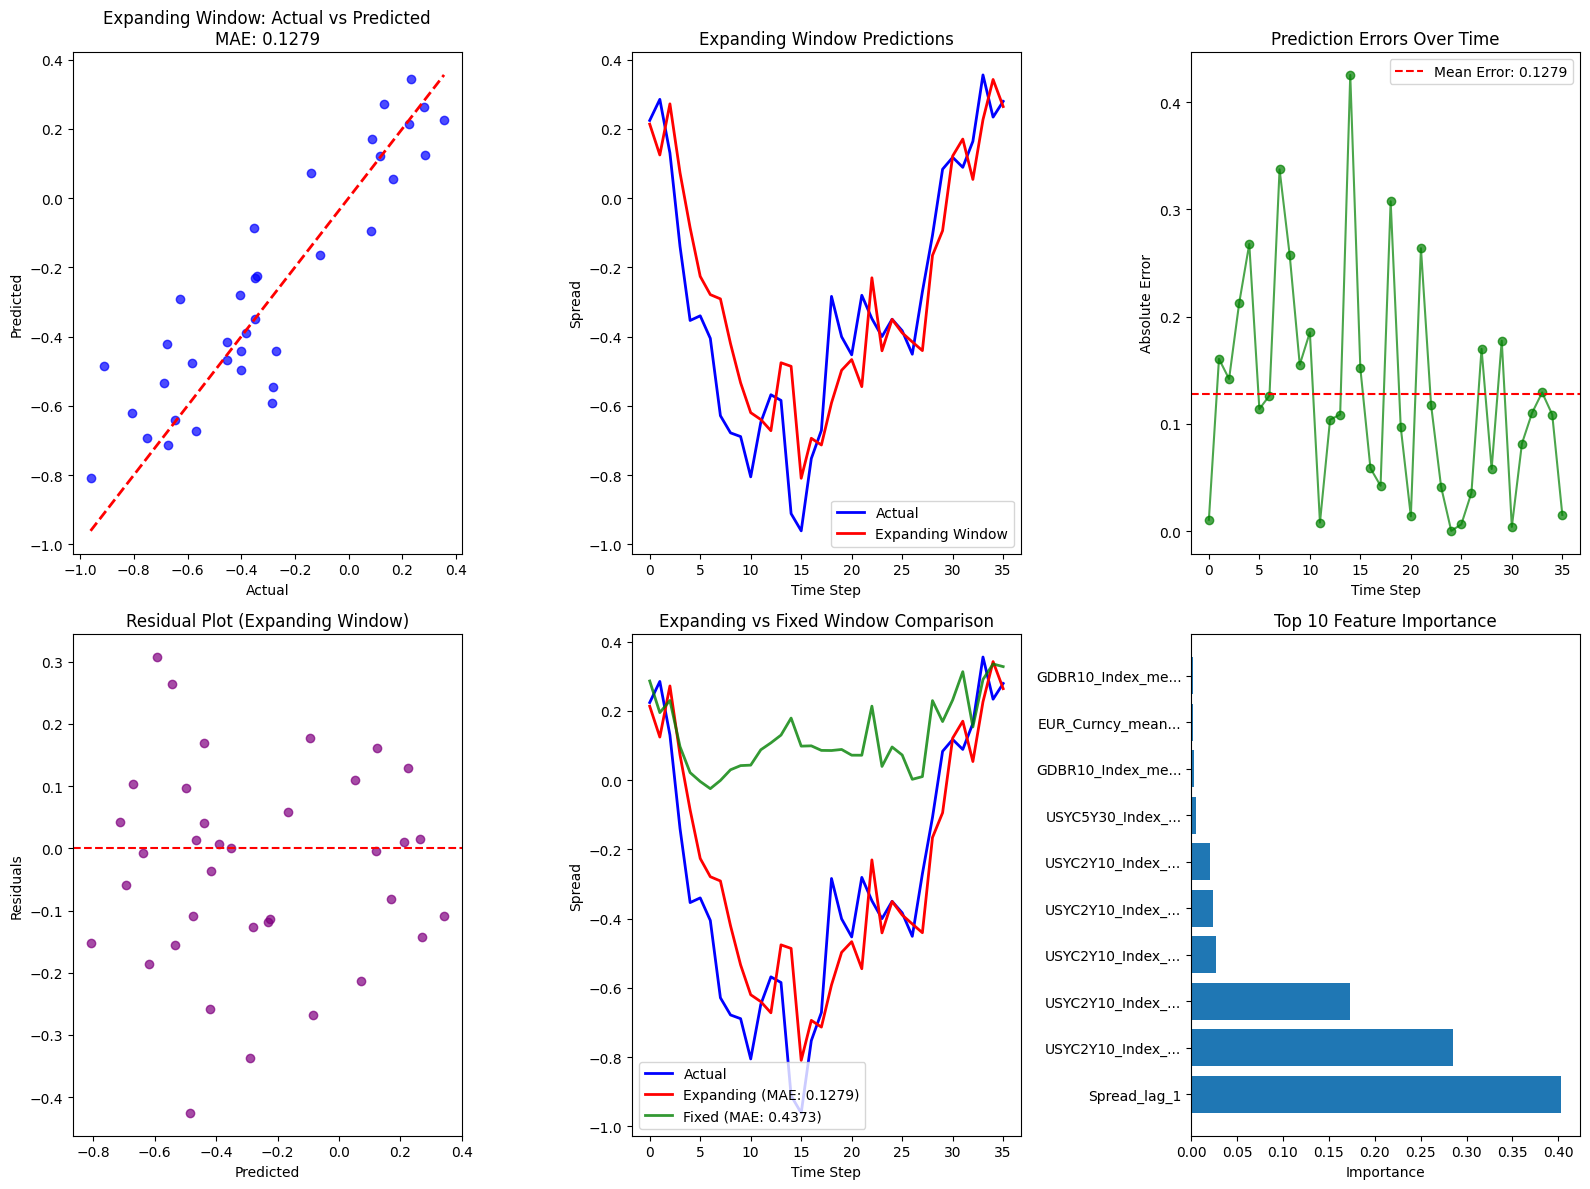

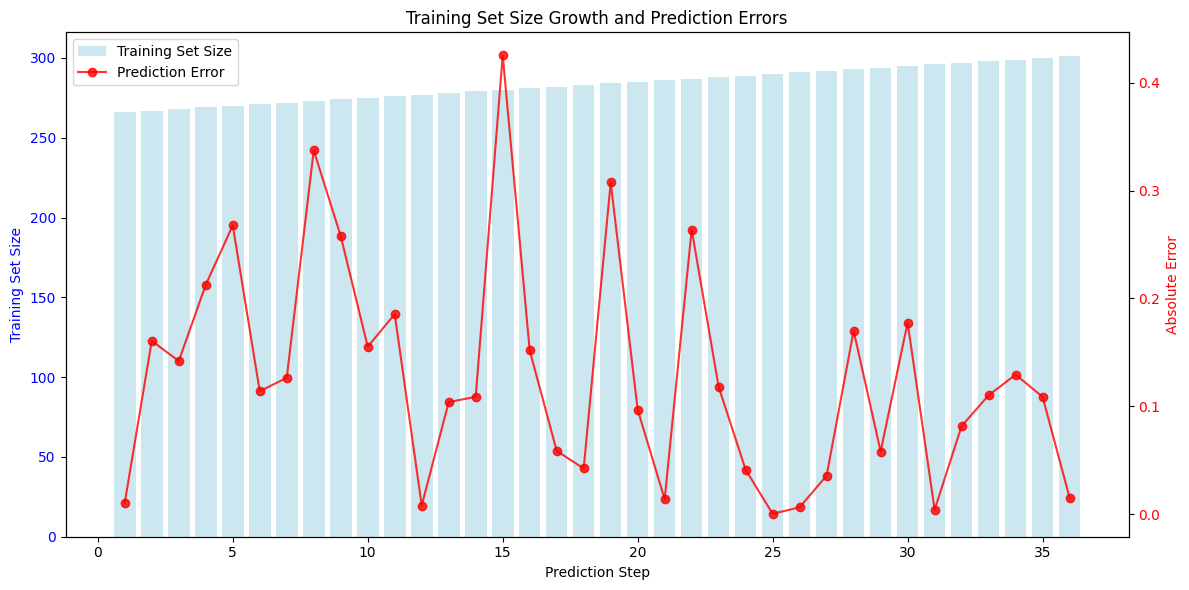

Cross-validation MAE: 0.2718 ± 0.1262


KeyError: 'test_mae'

In [52]:
# Example usage (uncomment whenimport numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

class XGBoostTimeSeriesForecaster:
    def __init__(self, target_col='Spread', test_size=36, cv_folds=5):
        self.target_col = target_col
        self.test_size = test_size
        self.cv_folds = cv_folds
        self.model = None
        self.scaler = None
        self.feature_names = None
        self.results = {}
        
    def create_lead_lag_features(self, df, other_cols=None, max_lags=5):
        """Create lag features and technical indicators"""
        feature_df = df.copy()
        
        # If no other columns specified, use all numeric columns except target
        if other_cols is None:
            other_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                         if col != self.target_col]
        
        print(f"Creating features for columns: {other_cols}")
        
        # Create lag features for target variable
        for lag in range(1, max_lags + 1):
            feature_df[f'{self.target_col}_lag_{lag}'] = feature_df[self.target_col].shift(lag)
        
        # Create features for other variables
        for col in other_cols:
            # Lag features
            for lag in range(1, max_lags + 1):
                feature_df[f'{col}_lag_{lag}'] = feature_df[col].shift(lag)
            
            # Rolling statistics
            for window in [3, 5, 10, 20]:
                feature_df[f'{col}_rolling_mean_{window}'] = feature_df[col].rolling(window).mean()
                feature_df[f'{col}_rolling_std_{window}'] = feature_df[col].rolling(window).std()
                feature_df[f'{col}_rolling_min_{window}'] = feature_df[col].rolling(window).min()
                feature_df[f'{col}_rolling_max_{window}'] = feature_df[col].rolling(window).max()
                
                # Rolling quantiles
                feature_df[f'{col}_rolling_q25_{window}'] = feature_df[col].rolling(window).quantile(0.25)
                feature_df[f'{col}_rolling_q75_{window}'] = feature_df[col].rolling(window).quantile(0.75)
            
            # Differencing features
            feature_df[f'{col}_diff_1'] = feature_df[col].diff(1)
            feature_df[f'{col}_diff_2'] = feature_df[col].diff(2)
            
            # Percentage change
            feature_df[f'{col}_pct_change'] = feature_df[col].pct_change()
            feature_df[f'{col}_pct_change_2'] = feature_df[col].pct_change(periods=2)
            
            # Momentum features
            for period in [3, 5, 10]:
                feature_df[f'{col}_momentum_{period}'] = feature_df[col] - feature_df[col].shift(period)
                feature_df[f'{col}_roc_{period}'] = (feature_df[col] / feature_df[col].shift(period) - 1) * 100
            
            # Volatility features
            feature_df[f'{col}_volatility_5'] = feature_df[col].rolling(5).std()
            feature_df[f'{col}_volatility_10'] = feature_df[col].rolling(10).std()
            
            # Technical indicators
            # RSI approximation
            delta = feature_df[col].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / loss
            feature_df[f'{col}_rsi'] = 100 - (100 / (1 + rs))
            
            # Bollinger Bands position
            sma_20 = feature_df[col].rolling(20).mean()
            std_20 = feature_df[col].rolling(20).std()
            feature_df[f'{col}_bb_position'] = (feature_df[col] - sma_20) / (2 * std_20)
        
        return feature_df
    
    def select_features(self, df, correlation_threshold=0.05, mutual_info_percentile=80):
        """Select features based on correlation and mutual information"""
        feature_cols = [col for col in df.columns if col != self.target_col and 
                       df[col].dtype in ['float64', 'int64']]
        
        # Remove rows with NaN in target
        clean_df = df.dropna(subset=[self.target_col])
        
        # Calculate correlations
        correlations = []
        for col in feature_cols:
            clean_data = clean_df[[self.target_col, col]].dropna()
            if len(clean_data) > 20:
                corr, p_val = pearsonr(clean_data[self.target_col], clean_data[col])
                correlations.append({
                    'feature': col,
                    'correlation': abs(corr),
                    'p_value': p_val
                })
        
        # Filter by correlation significance
        corr_df = pd.DataFrame(correlations)
        significant_features = corr_df[
            (corr_df['correlation'] > correlation_threshold) & 
            (corr_df['p_value'] < 0.05)
        ]['feature'].tolist()
        
        print(f"Features passing correlation filter: {len(significant_features)}")
        
        if len(significant_features) > 0:
            # Calculate mutual information for significant features
            X = clean_df[significant_features].fillna(clean_df[significant_features].mean())
            y = clean_df[self.target_col]
            
            mi_scores = mutual_info_regression(X, y, random_state=42)
            mi_threshold = np.percentile(mi_scores, mutual_info_percentile)
            
            # Select features above MI threshold
            selected_features = [feat for feat, score in zip(significant_features, mi_scores) 
                               if score >= mi_threshold]
            
            print(f"Features selected after MI filtering: {len(selected_features)}")
            return selected_features
        else:
            print("No features passed correlation filter, using top features by absolute correlation")
            return corr_df.nlargest(20, 'correlation')['feature'].tolist()
    
    def expanding_window_prediction(self, X, y, xgb_params, min_train_size=100):
        """Perform expanding window predictions on test set"""
        
        # Split data - use all but test_size for initial training + expanding
        n_total = len(X)
        n_train_initial = n_total - self.test_size
        
        if n_train_initial < min_train_size:
            raise ValueError(f"Not enough data for initial training. Need at least {min_train_size} points.")
        
        # Initialize results storage
        expanding_predictions = []
        expanding_actuals = []
        expanding_errors = []
        model_details = []
        
        print(f"\nPerforming expanding window predictions...")
        print(f"Initial training size: {n_train_initial}")
        print(f"Test predictions: {self.test_size}")
        print(f"Total expanding predictions: {self.test_size}")
        
        # For each point in test set, expand training and predict
        for i in range(self.test_size):
            # Current prediction point
            pred_idx = n_train_initial + i
            
            # Expanding training set (from start to current point - 1)
            train_end_idx = pred_idx
            X_train_expand = X.iloc[:train_end_idx].copy()
            y_train_expand = y.iloc[:train_end_idx].copy()
            
            # Current test point
            X_test_point = X.iloc[pred_idx:pred_idx+1].copy()
            y_test_point = y.iloc[pred_idx]
            
            # Train model on expanding window
            model = xgb.XGBRegressor(**xgb_params)
            model.fit(X_train_expand, y_train_expand)
            
            # Make prediction
            y_pred_point = model.predict(X_test_point)[0]
            
            # Store results
            expanding_predictions.append(y_pred_point)
            expanding_actuals.append(y_test_point)
            expanding_errors.append(abs(y_test_point - y_pred_point))
            
            # Store model details
            model_details.append({
                'prediction_step': i + 1,
                'train_size': len(X_train_expand),
                'actual': y_test_point,
                'predicted': y_pred_point,
                'error': abs(y_test_point - y_pred_point),
                'train_end_idx': train_end_idx,
                'pred_idx': pred_idx
            })
            
            if (i + 1) % 5 == 0 or i == 0:
                print(f"Step {i+1:2d}: Train size = {len(X_train_expand):4d}, "
                      f"Actual = {y_test_point:8.4f}, Predicted = {y_pred_point:8.4f}, "
                      f"Error = {abs(y_test_point - y_pred_point):8.4f}")
        
        # Calculate overall metrics
        expanding_mae = np.mean(expanding_errors)
        expanding_rmse = np.sqrt(np.mean([(a - p)**2 for a, p in zip(expanding_actuals, expanding_predictions)]))
        expanding_r2 = r2_score(expanding_actuals, expanding_predictions)
        
        print(f"\nExpanding Window Results:")
        print(f"MAE:  {expanding_mae:.4f}")
        print(f"RMSE: {expanding_rmse:.4f}")
        print(f"R²:   {expanding_r2:.4f}")
        
        return {
            'predictions': expanding_predictions,
            'actuals': expanding_actuals,
            'errors': expanding_errors,
            'mae': expanding_mae,
            'rmse': expanding_rmse,
            'r2': expanding_r2,
            'model_details': model_details
        }
    
    def time_series_cross_validation(self, X, y):
        """Perform time series cross-validation"""
        tscv = TimeSeriesSplit(n_splits=self.cv_folds)
        cv_scores = []
        fold_details = []
        
        print(f"\nPerforming {self.cv_folds}-fold time series cross-validation...")
        
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
            
            # Train model for this fold
            model = xgb.XGBRegressor(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1
            )
            
            model.fit(X_train_fold, y_train_fold)
            y_pred_fold = model.predict(X_val_fold)
            
            # Calculate metrics
            mae = mean_absolute_error(y_val_fold, y_pred_fold)
            mse = mean_squared_error(y_val_fold, y_pred_fold)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_val_fold, y_pred_fold)
            
            cv_scores.append(mae)
            fold_details.append({
                'fold': fold + 1,
                'train_size': len(train_idx),
                'val_size': len(val_idx),
                'mae': mae,
                'rmse': rmse,
                'r2': r2
            })
            
            print(f"Fold {fold + 1}: MAE = {mae:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}")
        
        cv_mean = np.mean(cv_scores)
        cv_std = np.std(cv_scores)
        
        print(f"\nCross-Validation Results:")
        print(f"Mean MAE: {cv_mean:.4f} ± {cv_std:.4f}")
        
        return cv_scores, fold_details, cv_mean, cv_std
    
    def fit_and_evaluate(self, data, other_features=None, xgb_params=None):
        """Main method to fit XGBoost model and evaluate performance"""
        
        print("="*80)
        print("XGBOOST TIME SERIES FORECASTING")
        print("="*80)
        print(f"Original data shape: {data.shape}")
        print(f"Target column: {self.target_col}")
        print(f"Test size: {self.test_size}")
        
        # Step 1: Feature Engineering
        print("\n1. Creating Features...")
        feature_data = self.create_lead_lag_features(data, other_features)
        print(f"Shape after feature engineering: {feature_data.shape}")
        
        # Step 2: Feature Selection
        print("\n2. Selecting Features...")
        selected_features = self.select_features(feature_data)
        print(f"Selected {len(selected_features)} features")
        
        # Step 3: Prepare data
        print("\n3. Preparing Data...")
        # Remove rows with NaN in target
        clean_data = feature_data.dropna(subset=[self.target_col]).copy()
        
        # Split into train and test sets
        train_data = clean_data[:-self.test_size].copy()
        test_data = clean_data[-self.test_size:].copy()
        
        print(f"Train data shape: {train_data.shape}")
        print(f"Test data shape: {test_data.shape}")
        
        # Prepare features and target
        X_train = train_data[selected_features].copy()
        y_train = train_data[self.target_col].copy()
        X_test = test_data[selected_features].copy()
        y_test = test_data[self.target_col].copy()
        
        # Handle missing values
        X_train = X_train.fillna(X_train.mean())
        X_test = X_test.fillna(X_train.mean())  # Use training means for test set
        
        # Remove features with no variance
        feature_vars = X_train.var()
        valid_features = feature_vars[feature_vars > 1e-8].index.tolist()
        X_train = X_train[valid_features]
        X_test = X_test[valid_features]
        
        print(f"Final feature count: {len(valid_features)}")
        self.feature_names = valid_features
        
        # Prepare full dataset for expanding window approach
        X_full = clean_data[valid_features].copy()
        y_full = clean_data[self.target_col].copy()
        
        # Handle missing values for full dataset
        X_full = X_full.fillna(X_full.mean())
        
        # Step 4: Time Series Cross-Validation (on training portion only)
        cv_scores, fold_details, cv_mean, cv_std = self.time_series_cross_validation(X_train, y_train)
        
        # Step 5: Expanding Window Predictions
        print("\n4. Performing Expanding Window Predictions...")
        
        # Default XGBoost parameters
        default_params = {
            'n_estimators': 200,
            'max_depth': 6,
            'learning_rate': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            'random_state': 42,
            'n_jobs': -1
        }
        
        if xgb_params:
            default_params.update(xgb_params)
        
        # Perform expanding window predictions
        expanding_results = self.expanding_window_prediction(X_full, y_full, default_params)
        
        # Step 6: Train final model on all available training data (for feature importance)
        print("\n5. Training Final Model for Feature Analysis...")
        self.model = xgb.XGBRegressor(**default_params)
        self.model.fit(X_train, y_train)
        
        # Traditional predictions for comparison
        y_pred_train = self.model.predict(X_train)
        y_pred_test = self.model.predict(X_test)
        
        # Calculate traditional metrics (for comparison)
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae_traditional = mean_absolute_error(y_test, y_pred_test)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse_traditional = np.sqrt(mean_squared_error(y_test, y_pred_test))
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2_traditional = r2_score(y_test, y_pred_test)
        
        # Step 7: Results Summary
        print("\n" + "="*80)
        print("RESULTS SUMMARY")
        print("="*80)
        
        print(f"\nCross-Validation Performance (Training Data):")
        print(f"Mean CV MAE: {cv_mean:.4f} ± {cv_std:.4f}")
        
        print(f"\n*** EXPANDING WINDOW PREDICTIONS (MAIN RESULTS) ***")
        print(f"Expanding Window MAE:  {expanding_results['mae']:.4f}")
        print(f"Expanding Window RMSE: {expanding_results['rmse']:.4f}")
        print(f"Expanding Window R²:   {expanding_results['r2']:.4f}")
        
        print(f"\nTraditional Fixed-Window Predictions (for comparison):")
        print(f"{'Metric':<15} {'Train':<12} {'Test':<12}")
        print(f"{'-'*40}")
        print(f"{'MAE':<15} {train_mae:<12.4f} {test_mae_traditional:<12.4f}")
        print(f"{'RMSE':<15} {train_rmse:<12.4f} {test_rmse_traditional:<12.4f}")
        print(f"{'R²':<15} {train_r2:<12.4f} {test_r2_traditional:<12.4f}")
        
        print(f"\nExpanding vs Fixed Window Comparison:")
        print(f"Expanding Window MAE: {expanding_results['mae']:.4f}")
        print(f"Fixed Window MAE:     {test_mae_traditional:.4f}")
        print(f"Improvement:          {((test_mae_traditional - expanding_results['mae']) / test_mae_traditional * 100):+.2f}%")
        
        # Detailed expanding window results
        print(f"\nDetailed Expanding Window Results (first 10 and last 5):")
        print(f"{'Step':<4} {'Train Size':<10} {'Actual':<10} {'Predicted':<10} {'Error':<10}")
        print(f"{'-'*55}")
        
        # Show first 10 predictions
        for detail in expanding_results['model_details'][:10]:
            print(f"{detail['prediction_step']:<4} {detail['train_size']:<10} "
                  f"{detail['actual']:<10.4f} {detail['predicted']:<10.4f} {detail['error']:<10.4f}")
        
        if len(expanding_results['model_details']) > 15:
            print("...")
            # Show last 5 predictions
            for detail in expanding_results['model_details'][-5:]:
                print(f"{detail['prediction_step']:<4} {detail['train_size']:<10} "
                      f"{detail['actual']:<10.4f} {detail['predicted']:<10.4f} {detail['error']:<10.4f}")
        
        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': valid_features,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"\nTop 10 Most Important Features:")
        print(f"{'Feature':<40} {'Importance':<12}")
        print(f"{'-'*55}")
        for _, row in feature_importance.head(10).iterrows():
            print(f"{row['feature']:<40} {row['importance']:<12.4f}")
        
        # Store results
        self.results = {
            'cv_scores': cv_scores,
            'cv_mean': cv_mean,
            'cv_std': cv_std,
            'fold_details': fold_details,
            
            # Expanding window results (main results)
            'expanding_window': expanding_results,
            'expanding_mae': expanding_results['mae'],
            'expanding_rmse': expanding_results['rmse'],
            'expanding_r2': expanding_results['r2'],
            
            # Traditional results (for comparison)
            'train_mae': train_mae,
            'test_mae_traditional': test_mae_traditional,
            'train_rmse': train_rmse,
            'test_rmse_traditional': test_rmse_traditional,
            'train_r2': train_r2,
            'test_r2_traditional': test_r2_traditional,
            
            'feature_importance': feature_importance,
            'predictions': {
                'y_train': y_train,
                'y_pred_train': y_pred_train,
                'y_test': y_test,
                'y_pred_test_traditional': y_pred_test,
                'expanding_predictions': expanding_results['predictions'],
                'expanding_actuals': expanding_results['actuals']
            },
            'selected_features': valid_features,
            'model_params': default_params
        }
        
        return self.results
    
    def plot_results(self, figsize=(16, 12)):
        """Plot results and diagnostics including expanding window results"""
        if not self.results:
            print("No results to plot. Run fit_and_evaluate first.")
            return
        
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        
        # Plot 1: Expanding Window - Actual vs Predicted
        expanding_actuals = self.results['expanding_window']['actuals']
        expanding_predictions = self.results['expanding_window']['predictions']
        
        axes[0, 0].scatter(expanding_actuals, expanding_predictions, alpha=0.7, color='blue')
        axes[0, 0].plot([min(expanding_actuals), max(expanding_actuals)], 
                       [min(expanding_actuals), max(expanding_actuals)], 
                       'r--', lw=2)
        axes[0, 0].set_xlabel('Actual')
        axes[0, 0].set_ylabel('Predicted')
        axes[0, 0].set_title(f'Expanding Window: Actual vs Predicted\nMAE: {self.results["expanding_mae"]:.4f}')
        
        # Plot 2: Time Series - Expanding Window Predictions
        test_indices = range(len(expanding_actuals))
        axes[0, 1].plot(test_indices, expanding_actuals, 
                       label='Actual', linewidth=2, color='blue')
        axes[0, 1].plot(test_indices, expanding_predictions, 
                       label='Expanding Window', linewidth=2, color='red')
        axes[0, 1].set_xlabel('Time Step')
        axes[0, 1].set_ylabel(self.target_col)
        axes[0, 1].set_title('Expanding Window Predictions')
        axes[0, 1].legend()
        
        # Plot 3: Prediction Errors Over Time
        expanding_errors = self.results['expanding_window']['errors']
        axes[0, 2].plot(test_indices, expanding_errors, 'o-', color='green', alpha=0.7)
        axes[0, 2].axhline(y=np.mean(expanding_errors), color='red', linestyle='--', 
                          label=f'Mean Error: {np.mean(expanding_errors):.4f}')
        axes[0, 2].set_xlabel('Time Step')
        axes[0, 2].set_ylabel('Absolute Error')
        axes[0, 2].set_title('Prediction Errors Over Time')
        axes[0, 2].legend()
        
        # Plot 4: Residuals (Expanding Window)
        expanding_residuals = np.array(expanding_actuals) - np.array(expanding_predictions)
        axes[1, 0].scatter(expanding_predictions, expanding_residuals, alpha=0.7, color='purple')
        axes[1, 0].axhline(y=0, color='r', linestyle='--')
        axes[1, 0].set_xlabel('Predicted')
        axes[1, 0].set_ylabel('Residuals')
        axes[1, 0].set_title('Residual Plot (Expanding Window)')
        
        # Plot 5: Comparison of Methods
        if 'y_pred_test_traditional' in self.results['predictions']:
            traditional_predictions = self.results['predictions']['y_pred_test_traditional']
            axes[1, 1].plot(test_indices, expanding_actuals, 
                           label='Actual', linewidth=2, color='blue')
            axes[1, 1].plot(test_indices, expanding_predictions, 
                           label=f'Expanding (MAE: {self.results["expanding_mae"]:.4f})', 
                           linewidth=2, color='red')
            axes[1, 1].plot(test_indices, traditional_predictions, 
                           label=f'Fixed (MAE: {self.results["test_mae_traditional"]:.4f})', 
                           linewidth=2, color='green', alpha=0.8)
            axes[1, 1].set_xlabel('Time Step')
            axes[1, 1].set_ylabel(self.target_col)
            axes[1, 1].set_title('Expanding vs Fixed Window Comparison')
            axes[1, 1].legend()
        
        # Plot 6: Feature Importance
        top_features = self.results['feature_importance'].head(10)
        axes[1, 2].barh(range(len(top_features)), top_features['importance'])
        axes[1, 2].set_yticks(range(len(top_features)))
        axes[1, 2].set_yticklabels([f[:15] + '...' if len(f) > 15 else f 
                                   for f in top_features['feature']])
        axes[1, 2].set_xlabel('Importance')
        axes[1, 2].set_title('Top 10 Feature Importance')
        
        plt.tight_layout()
        plt.show()
        
        # Additional plot: Training set size evolution
        if 'model_details' in self.results['expanding_window']:
            fig2, ax2 = plt.subplots(1, 1, figsize=(12, 6))
            
            model_details = self.results['expanding_window']['model_details']
            steps = [d['prediction_step'] for d in model_details]
            train_sizes = [d['train_size'] for d in model_details]
            errors = [d['error'] for d in model_details]
            
            ax2_twin = ax2.twinx()
            
            # Plot training set size
            ax2.bar(steps, train_sizes, alpha=0.6, color='lightblue', 
                   label='Training Set Size')
            ax2.set_xlabel('Prediction Step')
            ax2.set_ylabel('Training Set Size', color='blue')
            ax2.tick_params(axis='y', labelcolor='blue')
            
            # Plot prediction errors
            ax2_twin.plot(steps, errors, 'ro-', alpha=0.8, label='Prediction Error')
            ax2_twin.set_ylabel('Absolute Error', color='red')
            ax2_twin.tick_params(axis='y', labelcolor='red')
            
            plt.title('Training Set Size Growth and Prediction Errors')
            
            # Combined legend
            lines1, labels1 = ax2.get_legend_handles_labels()
            lines2, labels2 = ax2_twin.get_legend_handles_labels()
            ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
            
            plt.tight_layout()
            plt.show()

# Usage Example
def run_xgboost_forecast(data, target_col='Spread', other_features=None, test_size=36):
    """
    Main function to run XGBoost forecasting
    
    Parameters:
    -----------
    data : pd.DataFrame
        Your time series data
    target_col : str
        Name of target column to forecast
    other_features : list
        List of feature column names (if None, will use all numeric columns)
    test_size : int
        Number of recent observations to use for testing
    """
    
    # Initialize forecaster
    forecaster = XGBoostTimeSeriesForecaster(
        target_col=target_col,
        test_size=test_size,
        cv_folds=5
    )
    
    # Custom XGBoost parameters (optional)
    xgb_params = {
        'n_estimators': 300,
        'max_depth': 8,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1
    }
    
    # Fit and evaluate
    results = forecaster.fit_and_evaluate(
        data=data,
        other_features=other_features,
        xgb_params=xgb_params
    )
    
    # Plot results
    forecaster.plot_results()
    
    return forecaster, results

# Example usage (uncomment when you have your data):

# Assuming you have your data DataFrame ready
forecaster, results = run_xgboost_forecast(
    data=data,  # Your DataFrame
    target_col='Spread',
    other_features=None,  # Will auto-detect or specify: ['feature1', 'feature2', ...]
    test_size=36
)

# Access results
print(f"Cross-validation MAE: {results['cv_mean']:.4f} ± {results['cv_std']:.4f}")
print(f"Test MAE: {results['test_mae']:.4f}")

# Get feature importance
top_features = results['feature_importance'].head(10)
print("\nTop 10 Features:")
print(top_features)